In [163]:
# Imports and stable code

# Standard library imports
import time
import math
import copy
import os
os.environ["JULIA_NUM_THREADS"] = "1"
from julia.api import Julia
julia = Julia(sysimage="sysimage.so")
from julia import Main
Main.include("memory_model.jl")

import shutil
from tempfile import NamedTemporaryFile
import multiprocessing
from collections import deque
import re
import sqlite3

# Third-party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize, basinhopping, differential_evolution, OptimizeResult
from scipy.stats import qmc
from joblib import Parallel, delayed

# Infrastructure functions

#ASA Optimizer
# ASA Optimizer

def vfsa_accprob(curr_cost, new_cost, temp_acc):
    exponent = np.clip((new_cost - curr_cost) / temp_acc, -500, 500)
    return 1 / (1 + np.exp(exponent))

def vfsa_gen_step(dim, log_lb, log_ub, temp_gen, rng=None):
    if rng is None: 
        rng = np.random.default_rng()

    uni = rng.random(dim)
    base = 1 + 1 / (temp_gen + 1e-10)  # Small value added to avoid division by zero
    exponent = 2 * uni - 1
    rnd = np.sign(uni - 0.5) * temp_gen * (base**np.abs(exponent) - 1)
    return (log_ub - log_lb) * rnd

def vfsa_gen_params(curr_params, dim, log_lb, log_ub, temp_gen, rng=None):
    if rng is None: 
        rng = np.random.default_rng()

    log_params = np.log10(curr_params)
    flag1 = True

    while flag1:
        # Generate a log step
        log_step = vfsa_gen_step(dim, log_lb, log_ub, temp_gen, rng)
        new_log_params = log_params + log_step

        # Check if all new parameters are within bounds
        if np.all(new_log_params >= log_lb) and np.all(new_log_params <= log_ub):
            # If within bounds, convert back to linear scale and return
            par = 10 ** new_log_params
            flag1 = False
        else:
            # If any parameter is out of bounds, handle each one individually
            for i in range(dim):
                if new_log_params[i] < log_lb[i] or new_log_params[i] > log_ub[i]:
                    flag2 = True
                    while flag2:
                        # Generate a new step for the out-of-bounds parameter
                        log_step = vfsa_gen_step(dim, log_lb, log_ub, temp_gen, rng)
                        new_log_params[i] = log_params[i] + log_step[i]

                        # Check if it's now within bounds
                        if log_lb[i] <= new_log_params[i] <= log_ub[i]:
                            flag2 = False

            # Once all parameters are adjusted, convert to linear scale and exit loop
            par = 10 ** new_log_params
            flag1 = False

    return par
        
def vfsa_generinitpoint(dim, log_lb, log_ub, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    
    # Ensure that bounds are valid (finite numbers)
    if not (np.all(np.isfinite(log_lb)) and np.all(np.isfinite(log_ub))):
        raise ValueError("Bounds must be finite numbers")
    
    # Ensure bounds have proper order: log_lb should be less than or equal to log_ub
    if np.any(log_lb > log_ub):
        raise ValueError("Lower bounds must be less than or equal to upper bounds")
    
    flag = True
    while flag:
        # Generate random uniform numbers for each dimension
        uni = rng.random(dim)
        
        # Calculate log_initpoints within the bounds
        log_initpoints = log_lb + (log_ub - log_lb) * uni
        
        # Check if the new points are within the bounds (they should be)
        if np.all(log_initpoints >= log_lb) and np.all(log_initpoints <= log_ub):
            flag = False
    
    # Return the initial points, exponentiated back from log scale to original scale
    return 10 ** log_initpoints

def vfsa_reannealing(best_cost, best_params, curr_cost, dim, x0, tmax, tscat, data, c, temp_gen, temp0_gen, objective_function):
    log_orig_best_params = np.log10(best_params)
    log_par_delta = log_orig_best_params + 0.01 * log_orig_best_params
    par_delta = 10 ** log_par_delta
    
    cost_delta = np.array([
        objective_function(par_delta if i == j else best_params)
        for j in range(dim)
    ])
    
    par_diff = np.clip(par_delta - best_params, 1e-10, None)  # Avoid division by zero
    s = np.abs((cost_delta - best_cost) / par_diff) * (best_params / best_cost)
    smax = np.max(s)
    
    temp_gen = np.clip(temp_gen * (smax / np.clip(s, 1e-10, None)), 1e-10, None)
    
    k_gen = (-1/c * np.log(np.clip(temp_gen / temp0_gen, 1e-10, None))) ** dim
    k_gen = np.clip(k_gen, 0, None)  # Ensure non-negative values
    
    temp0_acc = curr_cost
    temp_acc = best_cost
    k_acc = (-1/c * np.log(np.clip(temp_acc / temp0_acc, 1e-10, None))) ** dim
    
    return temp_gen, k_gen, temp0_acc, temp_acc, k_acc

def vfsa_temp(temp_gen0, c, k_gen, dim, min_temp=1e-10):
    exponent = -c * np.power(k_gen, 1/dim)
    temp = temp_gen0 * np.exp(exponent)
    return np.clip(temp, min_temp, None)

def simulated_annealing(objective_function, initial_solution, lower_bounds, upper_bounds, 
                        initial_temperature, cooling_rate, max_iterations, neighborhood_function, 
                        log_lb, log_ub, temp_gen, 
                        M=10, eps=0.0, min_temp=1e-10, verbose=False):
    
    current_solution = initial_solution
    current_cost = objective_function(current_solution)
    best_solution = current_solution
    best_cost = current_cost
    temperature = initial_temperature

    reanneal_cost_vec = [best_cost]
    diff = deque(maxlen=M)
    best_diff = deque(maxlen=M)
    count_acc_points = 0

    for iteration in range(max_iterations):
        # Generate a new solution in the neighborhood
        new_solution = neighborhood_function(current_solution, len(current_solution), log_lb, log_ub, temp_gen)
        new_cost = objective_function(new_solution)
        delta_cost = new_cost - current_cost
        
        # Acceptance probability
        if delta_cost < 0 or np.random.rand() < np.exp(-delta_cost / temperature):
            current_solution = new_solution
            current_cost = new_cost
            count_acc_points += 1
            
            # Update the best solution found
            if current_cost < best_cost:
                best_solution = current_solution
                best_cost = current_cost

            # Reannealing: Store the best cost at this point
            reanneal_cost_vec.append(best_cost)
            if len(reanneal_cost_vec) > 1:
                diff.append(abs(reanneal_cost_vec[-1] - reanneal_cost_vec[-2]))
                best_diff.append(abs(reanneal_cost_vec[-1] - best_cost))

                # Termination condition based on the last M accepted costs
                if len(diff) == M and all(d <= eps for d in diff) and all(bd <= eps for bd in best_diff):
                    print('ASA converged, terminating at', iteration)
                    break
        
        # Decrease the temperature with a check for minimum temperature
        temperature = max(min_temp, temperature * cooling_rate)
        
        # Progress print statements
        if iteration % (max_iterations // 10) == 0:
            print(f"Iteration {iteration}")
            if verbose==True:
                print(f"Current cost = {current_cost}, Best cost = {best_cost}")
        
    return best_solution, best_cost

def ASA(objective_function, x0, bounds, maxiter=100, initial_temp=1.0, cooling_rate=0.95, 
        neighborhood_function=vfsa_gen_params, init_function=vfsa_generinitpoint, 
        **kwargs):
    
    dim = len(x0)
    lower_bounds, upper_bounds = np.array(bounds).T
    log_lb, log_ub = np.log10(lower_bounds), np.log10(upper_bounds)
    log_bounds = list(zip(log_lb, log_ub))
    
    # Generate the initial solution
    initial_solution = init_function(dim, log_lb, log_ub)
    
    # Run ASA optimization
    best_solution, best_cost = simulated_annealing(
        objective_function, initial_solution, lower_bounds, upper_bounds,
        initial_temp, cooling_rate, maxiter, neighborhood_function,
        log_lb, log_ub, initial_temp, verbose=False,
        **kwargs
    )
    print('ASA best cost:', best_cost)
    print(best_solution)

    # After simulated annealing, refine the solution with a local optimizer (e.g., L-BFGS-B)
    minimizer_kwargs = {
        'method': 'L-BFGS-B',
        'bounds': bounds,
        'options': {
            'disp': True,
            'maxiter': 250,
        }
    }

    local_result = minimize(
        objective_function,
        x0=best_solution,
        **minimizer_kwargs
    )
    
    final_solution = local_result.x
    final_cost = local_result.fun
    nfev = local_result.nfev
    success = local_result.success

    return OptimizeResult(x=final_solution, fun=final_cost, nfev=nfev, success=success)

class TimeManager:
    def __init__(self):
        self.start_time = time.time()

    def check_timeout(self, timeout: int) -> bool:
        return (time.time() - self.start_time) > timeout

    def reset_start_time(self):
        self.start_time = time.time()

    def get_elapsed_time(self) -> float:
        return time.time() - self.start_time

def unique_colors(ids):
    num_colors = len(ids)
    colors = sns.color_palette("husl", num_colors)
    return dict(zip(ids, colors))

class NoOpMinimizer:
    def __call__(self, x):
        return x

def format_fit_params(fit_parameters):
    if isinstance(fit_parameters, list) and len(fit_parameters) > 1:
        fit_params_str = " ".join(fit_parameters)
    else:
        fit_params_str = fit_parameters[0] if isinstance(fit_parameters, list) else fit_parameters
    
    # Define the replacements
    replacements = {
        r"\bd_E\b": "dE",  # d_E -> d subscript E
        r"\bdelta\b": "δ",  # delta -> δ
        r"\bdelta_E\b": "δE",  # delta_E -> δ subscript E
        r"\bK_delta_E\b": "K(δE)",  # K_delta_E -> K subscript δ subscript E
        r"\btau\b": "τ",  # tau -> τ
        r"\bxi\b": "ξ",  # xi -> ξ
        r"\bbeta\b": "β",  # beta -> β
        r"\bdelta_E/K_delta_E\b": "Log10 [δE/KδE]",  # delta_E/K_delta_E -> δ subscript E/K subscript δ subscript E
        r"\bdelta/delta_E\b": "δ/δE",  # delta/delta_E -> δ divided by δ subscript E
        r"\beta\b": "η",  # eta -> η
        r"\bzeta\b": "ζ",  # zeta -> ζ
        r"\btau_memory\b": "τm",  # tau_memory -> τ subscript m
    }

    # Apply the replacements using regex
    for pattern, replacement in replacements.items():
        fit_params_str = re.sub(pattern, replacement, fit_params_str)

    return fit_params_str

# Curent development area 
class Parameter:
    def __init__(self, name, val=None, l_lim=None, u_lim=None, method='fixed', space='log10'):
        self.name = name
        self.space = space
        self.l_lim = self._transform_space(l_lim)
        self.u_lim = self._transform_space(u_lim)
        self.val = val
        self.method = method

    def _transform_space(self, bound):
        if self.space == 'log10':
            return np.log10(bound)
        elif self.space == 'normal':
            return bound

    def _inverse_transform_space(self, value):
        if self.space == 'log10':
            return 10 ** value
        elif self.space == 'normal':
            return value

    def __repr__(self):
        return f"{self.val:.2e}"

    def sweep(self, num_points=100):
        values = np.linspace(self.l_lim, self.u_lim, num=num_points)
        if self.space == 'log10':
            values = 10 ** values  # Inverse transform back to natural space
        return [self._convert_to_type(val) for val in values]

class Parameters:
    def __init__(self, **kwargs):
        self._parameters = kwargs

    def __getattr__(self, item):
        if item in self._parameters:
            return self._parameters[item]
        raise AttributeError(f"'Parameters' object has no attribute '{item}'")

    def __setattr__(self, key, value):
        if key == '_parameters':
            super().__setattr__(key, value)
        else:
            self._parameters[key] = value

    def __getstate__(self):
        return self._parameters

    def __setstate__(self, state):
        self._parameters = state

    def items(self):
        return self._parameters.items()

    def __repr__(self):
        return f"Parameters({', '.join([f'{k}={v}' for k, v in self._parameters.items()])})"

    def load_parameters_from_dataframe(self, df_params, patient_id):
        if patient_id not in df_params['id'].values:
            print(f"ID {patient_id} not found in parameter file.")
            return
        param_values = df_params[df_params['id'] == patient_id].iloc[0]
        for param_name, param_obj in self._parameters.items():
            if param_obj.method == 'file' and param_name in param_values:
                param_val = param_values[param_name]
                if not np.isnan(param_val):
                    param_obj.val = param_val
                else:
                    print(f"Parameter '{param_name}' for ID {patient_id} is missing in the parameter file. Falling back to original values.")

class State:
    def __init__(self, label: str, initial_value: float = 0.0, sse: bool = False, scale: float = 1.0):
        self.label = label
        self.initial_value = initial_value
        self.time_points = np.array([0.0])
        self.sse = sse
        self.scale = scale

    def __repr__(self):
        return f"State(label={self.label}, initial_value={self.initial_value}, sse={self.sse})"

class States:
    def __init__(self, states_config: list):
        self.states = {config['label']: State(**config) for config in states_config}
        self.state_labels = [state.label for state in self.states.values()]

    def __getattr__(self, name: str) -> float:
        return self.states[name].get_latest_value()

    def __repr__(self):
        return f"States({', '.join([f'{k}={v}' for k, v in self.states.items()])}, sse={self.sse})"
    
class Patient:
    def __init__(self, id, color, t_span, df, parameters, states, df_params=None, sol=None, solve_time=np.nan, sse=np.inf, sse_statewise=np.inf):
        self.id = id
        self.color = color
        self.t_span = t_span
        self.df = df
        self.parameters = parameters
        self.states = states
        self.sol = sol
        self.solve_time = solve_time
        self.sse = sse
        self.sse_statewise = sse_statewise

        if df_params is not None:
            self.parameters.load_parameters_from_dataframe(df_params, self.id)
        self.param_names = list(self.parameters._parameters.keys())
        self.results_in_memory = []  # To store results for later DB writes

    def solve(self):
        try:
            self.sol = JuliaSolve((
                self.parameters, self.states, self.t_span
            ))
        except Exception as e:
            self.sol = None
            print(f"Error solving patient {self.id}: {e}")
    
    def compare(self):
        df = self.df
        shedders = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
        targets = [self.id]

        # States to include in SSE computation
        states_to_sse = ['V', 'CD8TE', 'CD8TM']

        for pid in targets:
            if isinstance(pid, str) and pid == 'Population':
                pid_df = df[df['VOLUNTEER'].isin(shedders)]
                pid_df['VOLUNTEER'] = 'Population'
            elif isinstance(pid, str) and pid == 'Murine':
                murine_ids = list(range(10))
                pid_df = df[df['VOLUNTEER'].isin(murine_ids)]
                pid_df['VOLUNTEER'] = 'Murine'
            else:
                pid_df = df[df['VOLUNTEER'].isin([pid])]

            # Initialize SSE array
            sse_array = [0] * len(self.states)
            total_sse = 0

            for idx, state in enumerate(self.states):
                state_label = state['label']
                if state_label in states_to_sse and state_label in pid_df.columns:
                    data_values = pid_df[state_label].values
                    time_points = pid_df['DAY'].values
                    valid_indices = ~np.isnan(data_values)
                    data_values = data_values[valid_indices]
                    time_points = time_points[valid_indices]

                    if len(data_values) > 0:
                        model_time_points = self.sol.t
                        model_values = self.sol.y[idx]

                        if model_values.shape[0] != len(model_time_points):
                            model_values = np.transpose(model_values)

                        # Interpolate model values to data time points
                        interpolated_model_values = np.interp(time_points, model_time_points, model_values)

                        # Calculate SSE for this state
                        state_sse = sum(
                            (np.log10(max(data_val, 1.0)) - np.log10(max(model_val, 1.0))) ** 2
                            for data_val, model_val in zip(data_values, interpolated_model_values)
                        )
                        sse_array[idx] = state_sse

                        # Accumulate total SSE if the state contributes to SSE
                        if state.get('sse', True):
                            if state_label in ['CD8TE', 'CD8TM']: 
                                total_sse += 1 * state_sse
                            else:
                                total_sse += 1*state_sse

            # Store total SSE and state-wise SSE
            self.sse = total_sse
            self.sse_statewise = sse_array

            # extract SSE for specific columns
            state_indices = {state['label']: idx for idx, state in enumerate(self.states)}
            sse_db_components = {label: sse_array[state_indices[label]] for label in states_to_sse if label in state_indices}
            sse_db = sum(sse_db_components.values())

            # Store parameters and SSEs in memory
            all_params = [param.val for param in self.parameters._parameters.values()]
            self.results_in_memory.append((all_params, list(sse_db_components.values()) + [sse_db], str(pid)))
    
    def objective_function(self, x):
        for i, name in enumerate(self.param_names):
            if self.parameters._parameters[name].space == 'log10':
                self.parameters._parameters[name].val = 10**x[i]
            else:
                self.parameters._parameters[name].val = x[i]

        self.solve()
        self.compare()

        return self.sse
    
    def write_results_to_db(self, path):
        conn = sqlite3.connect(path)
        cursor = conn.cursor()
        cursor.executemany('''
            INSERT INTO evaluations (
                E0, M0, ME, T0, I10, beta, k, p, c, delta, xi, a, d_E, delta_E, K_delta_E,
                zeta, eta, K_I1, tau_memory, V_sse, CD8TE_sse, CD8TM_sse, sse, PID
            ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
        ''', [tuple(p) + tuple(e) + (pid,) for p, e, pid in self.results_in_memory])
        conn.commit()
        conn.close()
        self.results_in_memory = [] # Flush the results from memory
        print(f'Results saved to {path}.',flush=True)

    def optimize_parameters(self, method='halton', iter=1000, verbose=False, path='output', local_iter=1000, local_method='L-BFGS-B', seed=34):
        fit_parameters = {name: param for name, param in self.parameters._parameters.items() if param.method == 'fit'}

        if not fit_parameters:
            print("No parameters to optimize")
            self.solve()
            self.compare()
            return (None, self)

        
        #initial_values = [np.log10(param.val) if param.space == 'log10' else param.val for param in fit_parameters.values()]
        initial_values = []
        for param in fit_parameters.values():
            sampled_value = np.random.uniform(param.l_lim, param.u_lim)
            if param.space == 'log10':
                initial_values.append(10**sampled_value)
            else:
                initial_values.append(sampled_value)

        bounds = [(param.l_lim, param.u_lim) for param in fit_parameters.values()]
        self.param_names = list(fit_parameters.keys())  # Save param_names as instance variable
        number_fit = len(self.param_names)

        minimizer_kwargs = {
            'method': local_method,
            'bounds': bounds,
            'options': {
                    'xatol': 1e-6,
                    'fatol': 1e-6,
                    'disp': verbose,
                    'maxiter': local_iter,
            }}

        if method == 'differential_evolution':

            print(f'{self.id} Differential Evolution with {iter} generations.',flush=True)
            # Single instance of DE in serial
            result = differential_evolution(
                self.objective_function,
                bounds=bounds,
                strategy='best1bin',
                maxiter=iter,
                popsize=100,
                mutation=(0.2, 0.9),
                recombination=0.9,
                seed=seed,
                disp=verbose,
                polish=True,
                init='halton',
                workers=1, 
                vectorized=False
            )
        
        elif method == 'ASA':
            result = ASA(
                self.objective_function,
                x0=initial_values, 
                bounds=bounds,
                maxiter=iter,
                initial_temp=1.0,
                cooling_rate=0.95,
                neighborhood_function=vfsa_gen_params,
                init_function=vfsa_generinitpoint,
                M=15,  # Number of accepted costs for convergence
                eps=1e-6
            )
        
        elif method == 'basin_hopping':
            class BoundedStep:
                def __init__(self, fit_parameters, stepsize=0.5, normal_sampling=False):
                    self.fit_parameters = fit_parameters
                    self.stepsize = stepsize
                    self.normal_sampling = normal_sampling
                    self.precomputed = {}

                    for i, (param_name, param) in enumerate(self.fit_parameters.items()):
                        lower, upper = param.l_lim, param.u_lim
                        if param.space == 'log10':
                            lower, upper = np.log10(lower), np.log10(upper)

                        self.precomputed[i] = {
                            'lower': lower,
                            'upper': upper,
                            'range': upper - lower,
                            'is_log': param.space == 'log10'
                        }

                def __call__(self, x):
                    rng = np.random.default_rng(seed)

                    for i in range(len(x)):
                        bounds = self.precomputed[i]
                        lower, upper, range_, is_log = bounds['lower'], bounds['upper'], bounds['range'], bounds['is_log']

                        if self.normal_sampling:
                            # Sample from a normal distribution, transform to [0, 1], then to desired range
                            step = rng.normal(0, self.stepsize)  # Step in standard normal space
                            step = np.clip(step, -3, 3)  # Clip to a range that mostly falls within [-3, 3] std devs
                            normalized_step = (step + 3) / 6  # Map from [-3, 3] to [0, 1]
                        else:
                            # Uniform sampling in [0, 1]
                            normalized_step = rng.uniform()

                        # Transform normalized step to the target range
                        step = (normalized_step - 0.5) * self.stepsize * range_

                        # Apply step and clip to the transformed bounds
                        x[i] = np.clip(x[i] + step, lower, upper)

                        # Transform back to the original space if necessary
                        if is_log:
                            x[i] = 10 ** x[i]

                    return x

            print(f'{self.id} Basin Hopping with n = {iter}',flush=True)
            result = basinhopping(
                self.objective_function,  
                x0=initial_values,
                niter=iter,
                T=0.01,
                stepsize=1.0,
                minimizer_kwargs=minimizer_kwargs,
                take_step=BoundedStep(fit_parameters, stepsize=1.0),
                interval=1,
                disp=verbose,
                niter_success=2,
                seed=seed,
                target_accept_rate=0.5,
                stepwise_factor=0.8,
            )
        
        elif method == 'halton':
            print(f'{self.id} Halton with n = {iter}', flush=True)
            # Halton sampling-based optimization
            sampler = qmc.Halton(d=number_fit)
            n_samples = iter  # Number of samples for Halton sequence
            step_size = n_samples // 20  # 5% of n_samples

            # Generate Halton samples in [0, 1] and scale them to the parameter bounds
            halton_samples = sampler.random(n_samples)
            scaled_samples = qmc.scale(halton_samples, [b[0] for b in bounds], [b[1] for b in bounds])
            best_sample = None
            best_sse = np.inf
            progress_count = 0

            for i, sample in enumerate(scaled_samples):
                sse = self.objective_function(sample)
                if sse < best_sse:
                    best_sse = sse
                    best_sample = sample

                # Print progress every 5% 
                if (i + 1) % step_size == 0:
                    progress_count += 5
                    print(f"Progress: {progress_count}% of samples evaluated ({i+1}/{n_samples})")

            # Assign the best-found parameters back to the model
            result = OptimizeResult()
            result.x = best_sample
            result.fun = best_sse
        
        else: # Local solver fallback 
            fallback_minimizer_kwargs = {
            'method': local_method,
            'bounds': bounds,
            'options': {
                    'xatol': 1e-6,
                    'fatol': 1e-6,
                    'disp': True,
                    'maxiter': iter,
            }}
            print(f'{self.id} {local_method} with n = {iter}',flush=True)
            result = minimize(
                self.objective_function, 
                x0=initial_values,
                **fallback_minimizer_kwargs
            )

        # Write results to database
        db_path = f'sql/{path}.db'
        os.makedirs('sql', exist_ok=True)
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS evaluations (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                E0 REAL, M0 REAL, ME REAL, T0 REAL, I10 REAL, beta REAL, k REAL,
                p REAL, c REAL, delta REAL, xi REAL, a REAL,
                d_E REAL, delta_E REAL, K_delta_E REAL, zeta REAL, eta REAL, K_I1 REAL, tau_memory REAL,
                V_sse REAL, CD8TE_sse REAL, CD8TM_sse REAL, sse REAL, PID REAL
            )
        ''')
        conn.commit()
        conn.close()
        self.write_results_to_db(path=db_path)

        # Final update of parameters
        for i, name in enumerate(self.param_names):
            if self.parameters._parameters[name].space == 'log10':
                self.parameters._parameters[name].val = 10**result.x[i]
            else:
                self.parameters._parameters[name].val = result.x[i]
            print(f'Parameter {name}: {self.parameters._parameters[name].val}')

        # Solve and compare with the best-found parameters
        self.solve()
        self.results_in_memory = []
        Main.GC.gc()

        return (result, self)
    
    def __repr__(self):
        return f"Patient({self.id}, sse={self.sse}, parameters={self.parameters})"

class Patients:
    def __init__(self, ids, df, t_span, parameters, states, parameter_file=None):
        self.color_dict = unique_colors(ids)
        t_fill = np.linspace(t_span[0], t_span[-1], 250)
        t_int = np.arange(t_span[0], t_span[-1] + 1)
        self.t_span = np.unique(np.concatenate([t_span, t_fill, t_int]))
        self.df = df
        self.parameters = parameters
        self.states = states
        # Load the parameters from the Excel file once
        if parameter_file:
            self.df_params = self.load_excel_parameters(parameter_file)
        else:
            print('No parameters loaded: No file specified. Add parameter_file= to Patients initialization call.')
            self.df_params = None

        self.patients = {
            id: Patient(
                id,
                self.color_dict[id],
                self.t_span,
                self.df,
                copy.deepcopy(self.parameters),
                copy.deepcopy(self.states),
                self.df_params
            ) for id in ids
        }

        self.parameters.patients = self.patients

    def load_excel_parameters(self, parameter_file):
        parameter_file = os.path.abspath(parameter_file)
        df_params = None

        try:
            with NamedTemporaryFile(delete=False, suffix='.xlsx') as temp_file:
                temp_path = temp_file.name
                shutil.copyfile(parameter_file, temp_path)
            df_params = pd.read_excel(temp_path)

        except Exception as e:
            print(f"An error occurred: {e}")
            return None
        finally:
            if os.path.exists(temp_path):
                os.remove(temp_path)

        return df_params

    def solve(self):
        for patient in self.patients.values():
            patient.solve()
            
    def compare(self, ids=None):
        if ids is None:
            ids = self.patients.keys()
        for patient_id in ids:
            self.patients[patient_id].compare()
    
    def optimize_parameters(self, opt_target, method, iter, path, verbose=False, local_iter=1000, local_method='L-BFGS-B'):
        results = []
        for patient in self.patients.values():
            if patient.id == opt_target:
                result = patient.optimize_parameters(method=method, iter=iter, verbose=verbose, path=path, local_iter=local_iter, local_method=local_method)
                results.append(result)
        return results
    
    def sweep_parameter(self, param_name, num_points=10, percentage_range=None):
        param_to_sweep = self.parameters._parameters.get(param_name)
        if param_to_sweep is None:
            raise ValueError(f"Parameter {param_name} not found.")
        
        print(f'Sweeping parameter: {param_name}')
        
        if percentage_range is not None:
            initial_value = param_to_sweep.val
            lower_bound = initial_value * (1 - percentage_range / 100)
            upper_bound = initial_value * (1 + percentage_range / 100)
            if param_to_sweep.space == 'log10':
                l_lim_transformed = np.log10(lower_bound)
                u_lim_transformed = np.log10(upper_bound)
                sweep_values = np.linspace(l_lim_transformed, u_lim_transformed, num=num_points)
                sweep_values = 10 ** sweep_values
            elif param_to_sweep.space == 'normal':
                sweep_values = np.linspace(lower_bound, upper_bound, num=num_points)
            else:
                raise ValueError(f"Unsupported space type: {param_to_sweep.space}")
        else:
            sweep_values = param_to_sweep.sweep(num_points)

        sweep_ids = [f'S{i}' for i in range(num_points)]

        def solve_for_value(i, value, patient):
            patient.parameters._parameters[param_name].val = value
            patient.solve()
            patient.compare()
            return patient

        num_cores = multiprocessing.cpu_count() - 1

        # Parallel execution across patients
        sweep_patients = []
        for patient in self.patients.values():
            results = Parallel(n_jobs=num_cores)(
                delayed(solve_for_value)(i, value, patient)
                for i, value in enumerate(sweep_values)
            )
            sweep_patients.extend(results)

        return sweep_patients, sweep_values

    def __getitem__(self, id):
        patient = self.patients.get(id, None)
        if patient is not None:
            return repr(patient)
        return None

    def __repr__(self):
        return '\n'.join(repr(patient) for patient in self.patients.values())

class JuliaODESolution:
    def __init__(self, t, y):
        self.t = np.array(t)  # Time points
        self.y = np.array(y)  # Transposed solution values (states over time)

    def __repr__(self):
        return f"JuliaODESolution(t={self.t}, y={self.y})"

def solve_with_julia(t_span, y0, params):
    t_span = (float(np.float64(t_span[0])), float(np.float64(t_span[-1])))
    y0 = [float(np.float64(val)) for val in y0]

    params_julia = [
        float(np.float64(params["beta"])),
        float(np.float64(params["k"])),
        float(np.float64(params["p"])),
        float(np.float64(params["c"])),
        float(np.float64(params["delta"])),
        float(np.float64(params["xi"])),
        float(np.float64(params["a"])),
        float(np.float64(params["d_E"])),
        float(np.float64(params["delta_E"])),
        float(np.float64(params["K_delta_E"])),
        float(np.float64(params["zeta"])),
        float(np.float64(params["eta"])),
        float(np.float64(params["K_I1"])),
        float(np.float64(params["tau_memory"])),
    ]
    
    t_values, y_values = Main.tmap_LCTModel(t_span, y0, params_julia)
    t_values = np.array(t_values, dtype=np.float64)
    y_values = np.array(y_values, dtype=np.float64)

    return JuliaODESolution(t=t_values, y=y_values)

def JuliaSolve(task):
    def inner_solve(param_set, states_config, t_span):
        states_config_copy = states_config.copy()
        # Prepare parameters and initial conditions for Julia
        params = {
            "beta": param_set.beta.val,
            "k": param_set.k.val,
            "p": param_set.p.val,
            "c": param_set.c.val,
            "delta": param_set.delta.val,
            "xi": param_set.xi.val,
            "a": param_set.a.val,
            "d_E": param_set.d_E.val,
            "delta_E": param_set.delta_E.val,
            "K_delta_E": param_set.K_delta_E.val,
            "zeta": param_set.zeta.val,
            "eta": param_set.eta.val,
            "K_I1": param_set.K_I1.val,
            "tau_memory": param_set.tau_memory.val,
        }

        states_instance = States(states_config_copy)
        y0 = np.array([states_instance.states[config['label']].initial_value for config in states_config])
        y0[0] = param_set.T0.val
        y0[1] = param_set.I10.val
        y0[5] = param_set.ME.val
        sol = solve_with_julia(t_span, y0, params)
        sol.y[4] += param_set.E0.val  # Add the background T Effectors (E0)
        sol.y[5] += param_set.M0.val  # Add the background T Effector Memory (M0)
        return sol

    sol = inner_solve(*task)
    return sol

def plot(results, subplot_config, t_span=[0, 10], group=False, title=None, save=True, figsize=(10,10), patient_color='black'):

    x_ticks = np.arange(t_span[0], t_span[-1] + 1, 1)
    n_subplots = len(subplot_config)
    
    # Determine the number of rows and columns based on the number of subplots
    if n_subplots <= 4:
        n_rows, n_cols = 1, n_subplots
    else:
        n_rows, n_cols = int(np.ceil(np.sqrt(n_subplots))), int(np.ceil(n_subplots / np.sqrt(n_subplots)))

    if group:
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
        axs_flat = axs.flatten()
    
    base_font_size = 14

    title_font_size = base_font_size * 1.4
    label_font_size = base_font_size * 1.2
    tick_font_size = base_font_size * 0.9

    fit_params_set = set()
    for result, patient in results:
        patient_id = patient.id
        # Get only the parameters that were fit
        fit_parameters = [param_name for param_name, param in patient.parameters._parameters.items() if param.method == 'fit']
        fit_params_set.update(fit_parameters)

        if not group:
            if title is None:
                fit_params_str = format_fit_params(fit_parameters) if fit_parameters else ""
            else:
                fit_params_str = format_fit_params(title)
            title_str = f"Patient {patient_id}{': ' + fit_params_str if fit_params_str else ''}"
            fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
            axs_flat = axs.flatten()
            fig.suptitle(title_str, fontsize=title_font_size)

        for i, config in enumerate(subplot_config):
            ax = axs_flat[i]
            ax.set_title(config['title'], fontsize=title_font_size)

            # Handle data_keys
            data_keys = config['data_key'] if isinstance(config['data_key'], list) else [config['data_key']]
            markers = ['o', 's', '^', 'D', 'v']  # Different marker shapes

            for j, data_key in enumerate(data_keys):
                if data_key:
                    if isinstance(patient_id, str) and patient_id == 'Population':
                        ids_to_use = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
                        volunteer_data = patient.df[patient.df['VOLUNTEER'].isin(ids_to_use)].copy()
                    else:
                        volunteer_data = patient.df[patient.df['VOLUNTEER'].isin([patient_id])].copy()
                
                    ax.plot(volunteer_data['DAY'], np.log10(np.maximum(volunteer_data[data_key], 1.0)),
                            marker=markers[j % len(markers)], color=patient_color, linestyle='None', alpha=1.0, zorder=15)

            # Handle sol_keys
            sol_keys = config['sol_key'] if isinstance(config['sol_key'], list) else [config['sol_key']]
            linestyles = ['-', '--', '-.', ':']  # Different line styles

            if patient.sol:
                sol_t = patient.sol.t
                for k, sol_key in enumerate(sol_keys):
                    sol_y_raw = patient.sol.y[sol_key]
                    sol_y = np.log10(np.where(sol_y_raw < 1, 1, sol_y_raw))
                    ax.plot(sol_t, sol_y, color=patient_color, linestyle=linestyles[k % len(linestyles)], alpha=0.5)

            if config['ylims']:
                ax.set_ylim(config['ylims'])

            ax.set_xticks(x_ticks)
            ax.set_xlim([t_span[0] - 0.1, t_span[-1] + 0.1])
            ax.set_xlabel('time (d)', fontsize=label_font_size)
            ax.set_ylabel(f'log10 ({data_keys[0]})', fontsize=label_font_size)
            ax.tick_params(axis='both', which='major', labelsize=tick_font_size)

        for j in range(i + 1, len(axs_flat)):
            axs_flat[j].set_visible(False)

        if not group:
            plt.tight_layout()
            save_dir = os.path.join('plots', f'Patient_{patient_id}')
            os.makedirs(save_dir, exist_ok=True)
            save_path = os.path.join(save_dir, f'{fit_params_str}.png')
            if save: plt.savefig(save_path, bbox_inches='tight')
            plt.show()

    if group:
        fit_params_str = "_".join(sorted(fit_params_set))
        title_str = f"All Patients - Parameters {fit_params_str}"
        fig.suptitle(title_str, fontsize=title_font_size)
        
        plt.tight_layout()
        save_dir = os.path.join('plots', 'Grouped')
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'{fit_params_str}.png')
        if save: plt.savefig(save_path, bbox_inches='tight')
        plt.show()

In [32]:
shedders = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
targets = ['Population']
ids = targets + shedders
patient_color_names = [
'black',
'gray',
'purple',
'magenta',
'red',
'gold',
'darkorange',
'saddlebrown',
'mediumblue',
'dodgerblue',
'turquoise',
'darkgreen',
'lawngreen']
color_mapping = {id_: color for id_, color in zip(ids, patient_color_names)}

In [33]:
# Rahil Setup - Primary Infection
shedders = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
targets = ['Population']
ids = targets + shedders
subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, 'sol_key': 0, 'ylims': [0, 8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'ylims': [0, 8]},
    {'title': 'Infected Cells', 'data_key': None, 'sol_key': 2, 'ylims': [0, 8]},
    {'title': 'Virus', 'data_key': 'V', 'sol_key': 3,'ylims': [0,8]},
    {'title': 'T Effectors', 'data_key': 'CD8TE', 'sol_key': 4, 'ylims': [4,7.5]}, 
    #{'title': 'TEM', 'data_key': None, 'sol_key': 6, 'ylims': [2,7.5]},
    {'title': 'T Memory', 'data_key': 'CD8TM', 'sol_key': 5, 'ylims': [4,7.5]}, 
]

n_Z = 13
# Import data
df = pd.read_excel("../Data/Rahil_2020/Table8_Healed.xlsx", sheet_name='112Cens')
df_Rahil = df[['VOLUNTEER', 'DAY', 'V', 'IFNG', 'CD8TE', 'CD8TM']]
df_Rahil = df_Rahil.loc[df_Rahil['DAY'] < 9]
# LCT Model, Viral Parameters (p + 8 others)
states = [
    {'label': 'T', 'initial_value': 4E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TM', 'initial_value': 0.0, 'sse': True},
]

for i in range(1, n_Z + 1):
    states.append({'label': f'Z{i}', 'initial_value': 0.0, 'sse': False})
states.append({'label': 'CD8T_Tot', 'initial_value': 0.0, 'sse': False})


Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
ASA best cost: 4.32549265769203
[1.22668563e-04 3.13887723e-01 1.71869194e+01 3.15160210e-01
 3.21322426e-01 4.83967826e+00 6.41502690e-01 2.85558676e+00
 1.01669011e+04 1.27030814e-01 2.36642167e+00]
Results saved to sql/Draft_ASA.db.
Parameter beta: 0.00010042563696051798
Parameter p: 0.3142302869425085
Parameter c: 17.23933062755188
Parameter delta: 0.3269744438227529
Parameter xi: 0.33312882593892873
Parameter a: 4.840073149673793
Parameter d_E: 0.641207820933733
Parameter delta_E: 2.858649370607402
Parameter K_delta_E: 10166.90114071281
Parameter zeta: 0.12762321874526678
Parameter tau_memory: 2.367194409953851


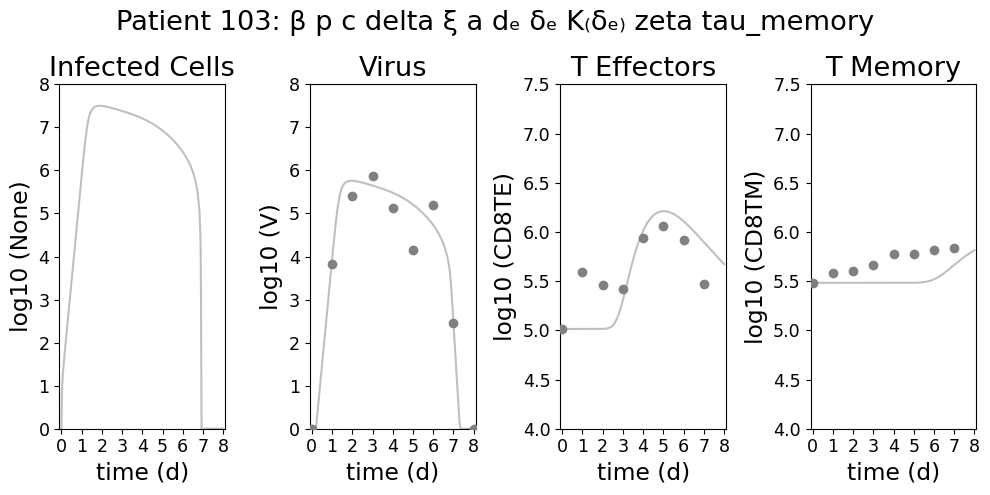

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
ASA best cost: 5.797994900243959
[4.59739626e-05 1.35767673e+00 6.22931985e+01 8.16124317e-01
 1.18250516e+00 1.90625803e+00 1.13486170e+00 7.12800412e-01
 1.60891486e+03 4.07196312e-02 6.07938978e-01]
Results saved to sql/Draft_ASA.db.
Parameter beta: 5.79524703970357e-05
Parameter p: 1.3618974954955152
Parameter c: 62.29312505249573
Parameter delta: 0.8277917994130575
Parameter xi: 1.1845719889627753
Parameter a: 1.913973079206361
Parameter d_E: 1.1339281088429558
Parameter delta_E: 0.7160958857757846
Parameter K_delta_E: 1608.9148615430174
Parameter zeta: 0.041205627569403755
Parameter tau_memory: 0.6079086269851346


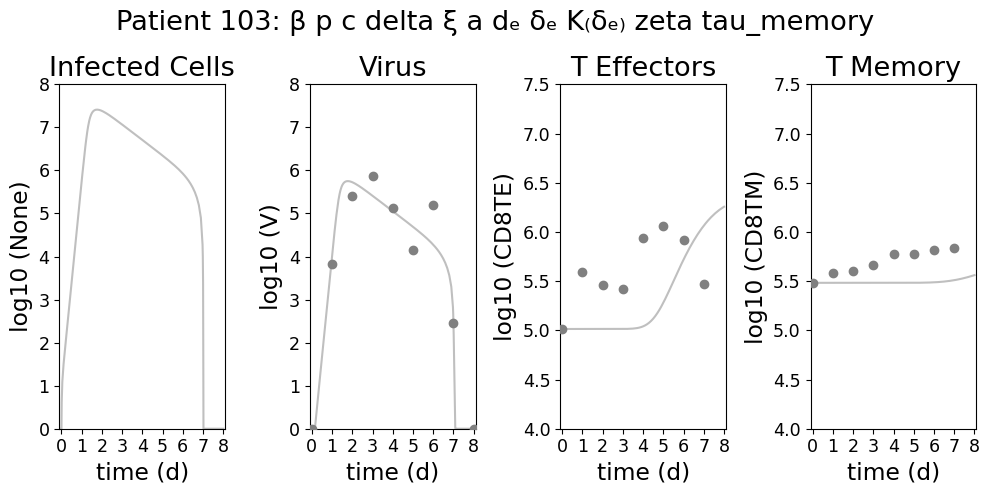

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
ASA best cost: 3.8364084073247247
[7.41909880e-05 9.21242685e-01 4.19994767e+01 8.59567905e-01
 2.33209955e-01 8.08124554e+00 6.75621124e-01 6.14882332e-01
 1.34813798e+02 2.15116697e-01 7.66250940e-01]
Results saved to sql/Draft_ASA.db.
Parameter beta: 5.162780169455927e-05
Parameter p: 0.918172193441695
Parameter c: 42.00040004526476
Parameter delta: 0.8767246264537771
Parameter xi: 0.2534330574583962
Parameter a: 8.079949080224536
Parameter d_E: 0.6745906103890325
Parameter delta_E: 0.6247820440023495
Parameter K_delta_E: 134.8137978709017
Parameter zeta: 0.21434980833874986
Parameter tau_memory: 0.7668390139522304


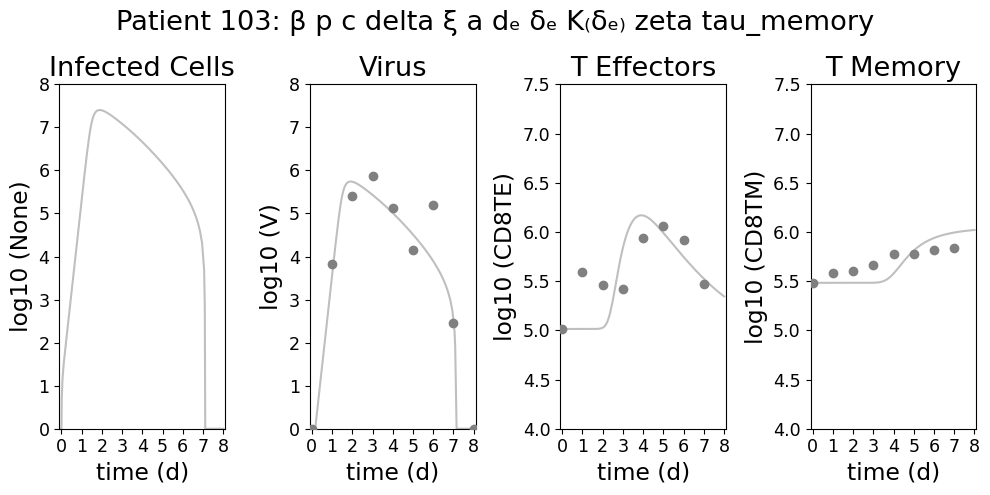

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
ASA best cost: 5.183083335973576
[7.06029600e-05 1.72250875e-01 3.92829458e+00 6.61493127e-01
 4.65070165e-01 3.72041016e+00 1.52373238e+00 2.95586663e+00
 1.02622339e+04 1.13835012e-01 2.44603961e+00]
Results saved to sql/Draft_ASA.db.
Parameter beta: 7.998883271125393e-05
Parameter p: 0.18299065903699377
Parameter c: 4.0332822472586045
Parameter delta: 0.6716983048359702
Parameter xi: 0.47549000474687064
Parameter a: 3.727272535963163
Parameter d_E: 1.52425285053558
Parameter delta_E: 2.9542717720858707
Parameter K_delta_E: 10262.233857079866
Parameter zeta: 0.11372153999895661
Parameter tau_memory: 2.4466449829852777


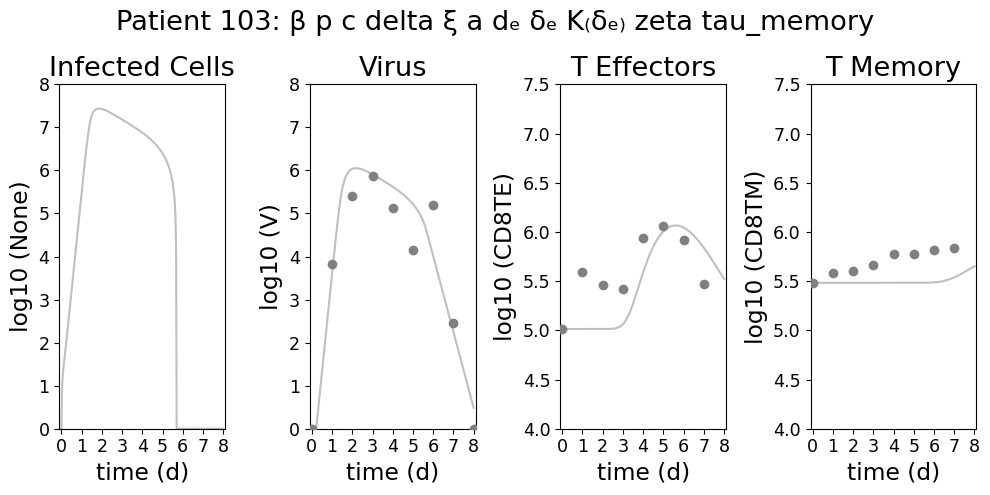

Iteration 0
Iteration 1000


KeyboardInterrupt: 

In [4]:
# Individual Fits ASA

parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2.1E4, u_lim=1.7E5, method='file', space='normal'),
    M0=Parameter(name='M0', val=1E4, l_lim=2E4, u_lim=3E5, method='file', space='normal'),
    ME=Parameter(name='ME', val=0, l_lim=2E4, u_lim=3E5, method='fixed', space='normal'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=8E7, method='fixed', space='normal'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='normal'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-6, u_lim=1E-2, method='fit', space='normal'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='normal'), 
    p=Parameter(name='p', val=4.184819, l_lim=0.1, u_lim=10, method='fit', space='normal'), 
    c=Parameter(name='c', val=10, l_lim=1.0, u_lim=100, method='fit', space='normal'), 
    delta=Parameter(name='delta', val=3, l_lim=0.1, u_lim=10, method='fit', space='normal'),
    xi=Parameter(name='xi', val=1.0, l_lim=0.1, u_lim=10, method='fit', space='normal'), 
    a=Parameter(name='a', val=5, l_lim=0.1, u_lim=10, method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.5, l_lim=0.4, u_lim=2, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=.75, l_lim=0.1, u_lim=10, method='fit', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=1.9E4, l_lim=1E2, u_lim=1E5, method='fit', space='normal'),
    zeta=Parameter(name='zeta', val=0.7, l_lim=0.01, u_lim=1, method='fit', space='normal'),
    eta=Parameter(name='eta', val=0, l_lim=1, u_lim=100, method='fixed', space='normal'), #2.7 for TEMs
    K_I1=Parameter(name='K_I1', val=10000, l_lim=1E2, u_lim=1E6, method='fixed', space='normal'),
    tau_memory=Parameter(name='tau_memory', val=2.5, l_lim=0.5, u_lim=3, method='fit', space='normal'),
)

t_span = (0, 8)
patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in [103]:
    for i in range(10):
        results = patients.optimize_parameters(method='ASA', opt_target=target, 
                                            iter=10000, verbose=True, path='Draft_ASA')

        plot(results, subplot_configuration, t_span, figsize=(10,5))

In [10]:
# Individual Fits p
parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2.1E4, u_lim=1.7E5, method='file', space='log10'),
    M0=Parameter(name='M0', val=1E4, l_lim=2E3, u_lim=3E4, method='file', space='log10'),
    ME=Parameter(name='ME', val=0, l_lim=2E4, u_lim=3E5, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=8E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-6, u_lim=1E-3, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=1, l_lim=0.05, u_lim=10, method='fit', space='normal'), 
    c=Parameter(name='c', val=10, l_lim=5.0, u_lim=500, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=3, l_lim=0.05, u_lim=5, method='fit', space='log10'),
    xi=Parameter(name='xi', val=1.0, l_lim=0.05, u_lim=10, method='fit', space='log10'), 
    a=Parameter(name='a', val=5, l_lim=1.0, u_lim=10, method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.5, l_lim=0.4, u_lim=2, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=.75, l_lim=0.5, u_lim=10, method='fit', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=1.9E4, l_lim=1E2, u_lim=1E5, method='fit', space='log10'),
    zeta=Parameter(name='zeta', val=0.07, l_lim=5E-4, u_lim=1E-1, method='fit', space='log10'),
    eta=Parameter(name='eta', val=0, l_lim=1, u_lim=100, method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=2.5, l_lim=0.25, u_lim=2, method='fit', space='normal'),
)

t_span = (0, 8)


patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in shedders:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=True, path='Draft_DE7')
    
    patient_color = color_mapping.get(target, 'black') 
    plot(results, subplot_configuration, t_span, figsize=(10,5), patient_color=patient_color)

103 Differential Evolution with 25 generations.


KeyboardInterrupt: 

Population Differential Evolution with 25 generations.


C:\Users\jorda\AppData\Local\Temp\ipykernel_18052\1409007726.py:418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pid_df['VOLUNTEER'] = 'Population'


differential_evolution step 1: f(x)= 304.6156032687085
differential_evolution step 2: f(x)= 273.11467333741564
differential_evolution step 3: f(x)= 273.11467333741564
differential_evolution step 4: f(x)= 273.11467333741564
differential_evolution step 5: f(x)= 269.8943351857175
differential_evolution step 6: f(x)= 269.8943351857175
differential_evolution step 7: f(x)= 268.6133657887337
differential_evolution step 8: f(x)= 268.1051433116316
differential_evolution step 9: f(x)= 266.83892379155714
differential_evolution step 10: f(x)= 266.8179595170401
differential_evolution step 11: f(x)= 266.629951550194
differential_evolution step 12: f(x)= 266.0482835808456
differential_evolution step 13: f(x)= 266.0199264106168
differential_evolution step 14: f(x)= 266.0199264106168
differential_evolution step 15: f(x)= 266.0199264106168
differential_evolution step 16: f(x)= 266.0199264106168
differential_evolution step 17: f(x)= 266.0199264106168
differential_evolution step 18: f(x)= 265.923919528241

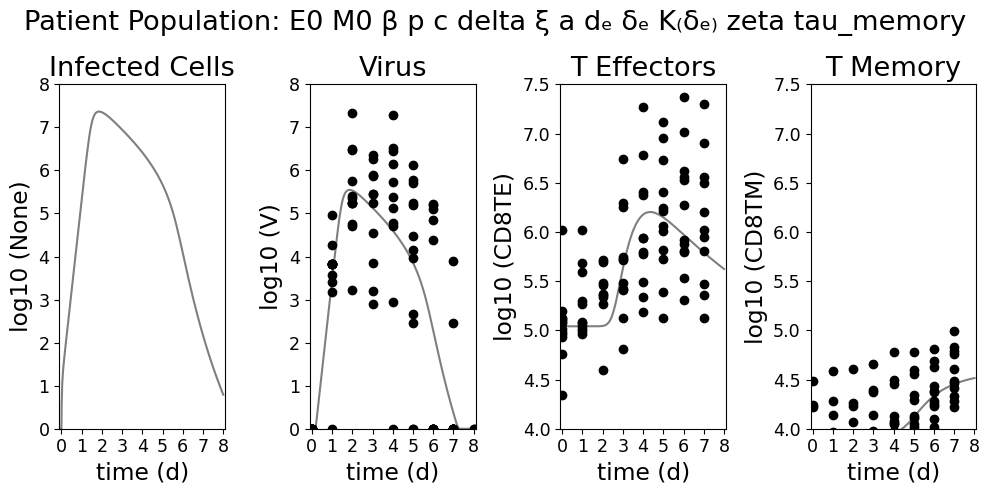

In [5]:
# Cohort fit p

parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2.1E4, u_lim=1.1E5, method='fit', space='log10'),
    M0=Parameter(name='M0', val=1E4, l_lim=2E3, u_lim=3E4, method='fit', space='log10'),
    ME=Parameter(name='ME', val=0, l_lim=2E4, u_lim=3E5, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=8E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-6, u_lim=1E-3, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=1, l_lim=0.05, u_lim=10, method='fit', space='normal'), 
    c=Parameter(name='c', val=10, l_lim=5.0, u_lim=500, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=3, l_lim=0.05, u_lim=5, method='fit', space='log10'),
    xi=Parameter(name='xi', val=1.0, l_lim=0.05, u_lim=10, method='fit', space='log10'), 
    a=Parameter(name='a', val=5, l_lim=1.0, u_lim=10, method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.5, l_lim=0.4, u_lim=2, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=.75, l_lim=0.5, u_lim=10, method='fit', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=1.9E4, l_lim=1E2, u_lim=1E5, method='fit', space='log10'),
    zeta=Parameter(name='zeta', val=0.07, l_lim=5E-4, u_lim=1E-1, method='fit', space='log10'),
    eta=Parameter(name='eta', val=0, l_lim=1, u_lim=100, method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=2.5, l_lim=0.25, u_lim=2, method='fit', space='normal'),
)

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in ['Population']:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=True, path='Draft_DE7')

    plot(results, subplot_configuration, t_span, figsize=(10,5))

In [3]:
# Individual Fits Dose

parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2.1E4, u_lim=1.7E5, method='file', space='log10'),
    M0=Parameter(name='M0', val=1E4, l_lim=2E3, u_lim=3E4, method='file', space='log10'),
    ME=Parameter(name='ME', val=0, l_lim=2E4, u_lim=3E5, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=8E7, method='fit', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-6, u_lim=1E-3, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=1.596, l_lim=0.05, u_lim=10, method='fixed', space='normal'), 
    c=Parameter(name='c', val=10, l_lim=5.0, u_lim=500, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=3, l_lim=0.05, u_lim=5, method='fit', space='log10'),
    xi=Parameter(name='xi', val=1.0, l_lim=0.05, u_lim=10, method='fit', space='log10'), 
    a=Parameter(name='a', val=5, l_lim=1.0, u_lim=10, method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.5, l_lim=0.4, u_lim=2, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=.75, l_lim=0.5, u_lim=10, method='fit', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=1.9E4, l_lim=1E2, u_lim=1E5, method='fit', space='log10'),
    zeta=Parameter(name='zeta', val=0.07, l_lim=5E-4, u_lim=1E-1, method='fit', space='log10'),
    eta=Parameter(name='eta', val=0, l_lim=1, u_lim=100, method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=2.5, l_lim=0.25, u_lim=2, method='fit', space='normal'),
)

t_span = (0, 8)
shedders = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
targets = ['Population']
ids = targets + shedders
patient_color_names = [
'black',
'gray',
'purple',
'magenta',
'red',
'gold',
'darkorange',
'saddlebrown',
'mediumblue',
'dodgerblue',
'turquoise',
'darkgreen',
'lawngreen']
color_mapping = {id_: color for id_, color in zip(ids, patient_color_names)}

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in shedders:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=True, path='Draft_dose_DE7')
    
    patient_color = color_mapping.get(target, 'black') 
    plot(results, subplot_configuration, t_span, figsize=(10,5), patient_color=patient_color)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

Population Differential Evolution with 50 generations.


C:\Users\jorda\AppData\Local\Temp\ipykernel_18052\1409007726.py:418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pid_df['VOLUNTEER'] = 'Population'


differential_evolution step 1: f(x)= 303.02517926975753
differential_evolution step 2: f(x)= 279.38398186188533
differential_evolution step 3: f(x)= 279.38398186188533
differential_evolution step 4: f(x)= 277.9445458864112
differential_evolution step 5: f(x)= 275.74312751530084
differential_evolution step 6: f(x)= 275.74312751530084
differential_evolution step 7: f(x)= 269.1342029630114
differential_evolution step 8: f(x)= 269.1342029630114
differential_evolution step 9: f(x)= 269.1342029630114
differential_evolution step 10: f(x)= 269.1342029630114
differential_evolution step 11: f(x)= 268.8945031827612
differential_evolution step 12: f(x)= 268.1462402361313
differential_evolution step 13: f(x)= 267.7671512242473
differential_evolution step 14: f(x)= 267.55341986743133
differential_evolution step 15: f(x)= 267.44751174299597
differential_evolution step 16: f(x)= 267.44751174299597
differential_evolution step 17: f(x)= 267.4049524505093
differential_evolution step 18: f(x)= 267.0970292

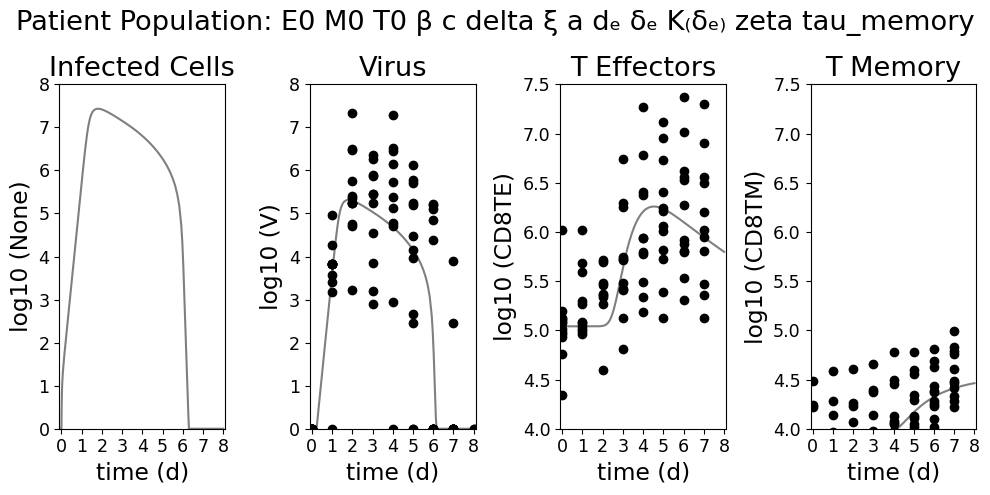

In [7]:
# cohort fit dose 
parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2.1E4, u_lim=1.1E5, method='fit', space='log10'),
    M0=Parameter(name='M0', val=1E4, l_lim=2E3, u_lim=3E4, method='fit', space='log10'),
    ME=Parameter(name='ME', val=0, l_lim=2E4, u_lim=3E5, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=8E7, method='fit', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-6, u_lim=1E-3, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=1.596, l_lim=0.05, u_lim=10, method='fixed', space='normal'), 
    c=Parameter(name='c', val=10, l_lim=5.0, u_lim=500, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=3, l_lim=0.05, u_lim=5, method='fit', space='log10'),
    xi=Parameter(name='xi', val=1.0, l_lim=0.05, u_lim=10, method='fit', space='log10'), 
    a=Parameter(name='a', val=5, l_lim=1.0, u_lim=10, method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.5, l_lim=0.4, u_lim=2, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=.75, l_lim=0.5, u_lim=10, method='fit', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=1.9E4, l_lim=1E2, u_lim=1E5, method='fit', space='log10'),
    zeta=Parameter(name='zeta', val=0.07, l_lim=5E-4, u_lim=1E-1, method='fit', space='log10'),
    eta=Parameter(name='eta', val=0, l_lim=1, u_lim=100, method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=2.5, l_lim=0.25, u_lim=2, method='fit', space='normal'),
)

t_span = (0, 8)
#[103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in ['Population']:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=50, verbose=True, path='Draft_Dose_DE7')

    plot(results, subplot_configuration, t_span, figsize=(10,5))

In [34]:
def plot_per_patient_both_sets(
    results,
    results_rechallenge,
    subplot_config,
    t_span=[0, 10],
    figsize=(10,5),
    patient_color='blue',
    save=True
):
    """
    Create one figure per patient, plotting lines from `results` (patient_color)
    and `results_rechallenge` (black). We assume both lists contain the same patients
    in the same order, or at least they line up in a meaningful way.

    Args:
        results (list): List of (result_obj, patient_obj) for the first scenario.
        results_rechallenge (list): Same as `results`, but for the second scenario.
        subplot_config (list): A list of subplot definitions. Each dict might have
            'title', 'data_key', 'sol_key', 'ylims', etc.
        t_span (list): Time span for x-axis.
        figsize (tuple): Size of the per-patient figure.
        patient_color (str): Color for the first scenario's lines.
        save (bool): Whether to save the figure to disk.
    """
    # Prepare x-ticks
    x_ticks = np.arange(t_span[0], t_span[-1] + 1, 1)

    # Determine subplot grid
    n_subplots = len(subplot_config)
    if n_subplots <= 4:
        n_rows, n_cols = 1, n_subplots
    else:
        n_rows = int(np.ceil(np.sqrt(n_subplots)))
        n_cols = int(np.ceil(n_subplots / n_rows))

    # Font sizes
    base_font_size = 14
    title_font_size = base_font_size * 1.4
    label_font_size = base_font_size * 1.2
    tick_font_size = base_font_size * 0.9

    # We'll loop over both sets simultaneously using zip(...)
    # We assume results and results_rechallenge have the same length and matching patients.
    for (res_obj1, patient1), (res_obj2, patient2) in zip(results, results_rechallenge):
        # Typically patient1 and patient2 represent the SAME patient (same ID)
        patient_id = patient1.id  # hopefully patient2.id matches

        # Collect fit parameters from the first scenario (you could combine both if needed)
        fit_parameters = [
            param_name
            for param_name, param in patient1.parameters._parameters.items()
            if param.method == 'fit'
        ]
        fit_params_str = format_fit_params(fit_parameters) if fit_parameters else ""

        # Create figure and subplots for this patient
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize, squeeze=False)
        axs_flat = axs.flatten()

        # Figure title
        title_str = f"Patient {patient_id}: {fit_params_str}"
        fig.suptitle(title_str, fontsize=title_font_size)

        # Plot each subplot
        for i, config in enumerate(subplot_config):
            ax = axs_flat[i]
            # Title of each subplot
            ax.set_title(config['title'], fontsize=title_font_size)

            # Plot data from the first scenario (results)
            data_keys = config['data_key'] if isinstance(config['data_key'], list) else [config['data_key']]
            markers = ['o', 's', '^', 'D', 'v']
            
            for j, data_key in enumerate(data_keys):
                if data_key:
                    # Filter volunteer data for this patient
                    volunteer_data = patient1.df[
                        patient1.df['VOLUNTEER'] == patient_id
                    ].copy()
                    ax.plot(
                        volunteer_data['DAY'],
                        np.log10(np.maximum(volunteer_data[data_key], 1.0)),
                        marker=markers[j % len(markers)],
                        color=patient_color,
                        linestyle='None',
                        alpha=1.0,
                        zorder=15
                    )

            # Plot model solution from the first scenario (results)
            sol_keys = config['sol_key'] if isinstance(config['sol_key'], list) else [config['sol_key']]
            linestyles = ['-', '--', '-.', ':']
            if patient1.sol:
                sol_t = patient1.sol.t
                for k, sol_key in enumerate(sol_keys):
                    sol_y_raw = patient1.sol.y[sol_key]
                    sol_y = np.log10(np.where(sol_y_raw < 1, 1, sol_y_raw))
                    ax.plot(
                        sol_t,
                        sol_y,
                        color=patient_color,
                        linestyle=linestyles[k % len(linestyles)],
                        alpha=1.0
                    )
            
            # Now plot data + model lines from the second scenario (results_rechallenge) in black
            if patient2.df is not None:
                for j, data_key in enumerate(data_keys):
                    if data_key:
                        volunteer_data = patient2.df[
                            patient2.df['VOLUNTEER'] == patient2.id
                        ].copy()
                        ax.plot(
                            volunteer_data['DAY'],
                            np.log10(np.maximum(volunteer_data[data_key], 1.0)),
                            marker=markers[j % len(markers)],
                            color=patient_color,
                            linestyle='None',
                            alpha=1.0,
                            zorder=15
                        )
            if patient2.sol:
                sol_t = patient2.sol.t
                for k, sol_key in enumerate(sol_keys):
                    sol_y_raw = patient2.sol.y[sol_key]
                    sol_y = np.log10(np.where(sol_y_raw < 1, 1, sol_y_raw))
                    ax.plot(
                        sol_t,
                        sol_y,
                        color='black',
                        linestyle=linestyles[k % len(linestyles)],
                        alpha=1.0
                    )

            # Axis limits, labels, etc.
            if 'ylims' in config and config['ylims']:
                ax.set_ylim(config['ylims'])
            ax.set_xticks(x_ticks)
            ax.set_xlim([t_span[0] - 0.1, t_span[-1] + 0.1])
            ax.set_xlabel('time (d)', fontsize=label_font_size)
            # Label y-axis based on first data_key (if present)
            if len(data_keys) > 0 and data_keys[0]:
                ax.set_ylabel(f'log10({data_keys[0]})', fontsize=label_font_size)
            ax.tick_params(axis='both', which='major', labelsize=tick_font_size)

        # Hide unused subplots if any
        for extra_ax in axs_flat[len(subplot_config):]:
            extra_ax.set_visible(False)

        plt.tight_layout()

        # Save the figure if desired
        save_dir = os.path.join('plots', f'Patient_{patient_id}')
        os.makedirs(save_dir, exist_ok=True)
        save_path = os.path.join(save_dir, f'{fit_params_str}.png')
        if save:
            plt.savefig(save_path, bbox_inches='tight')
        plt.show()

No parameters to optimize
No parameters to optimize


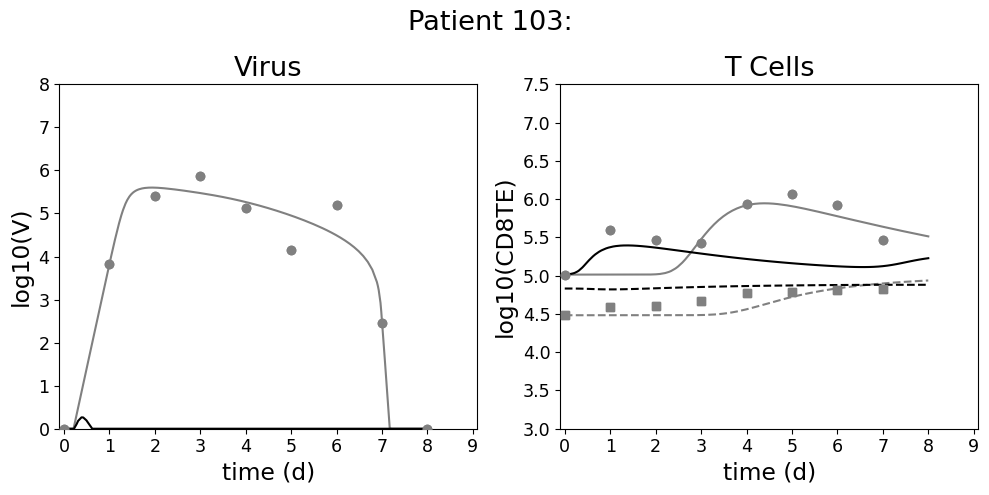

No parameters to optimize
No parameters to optimize


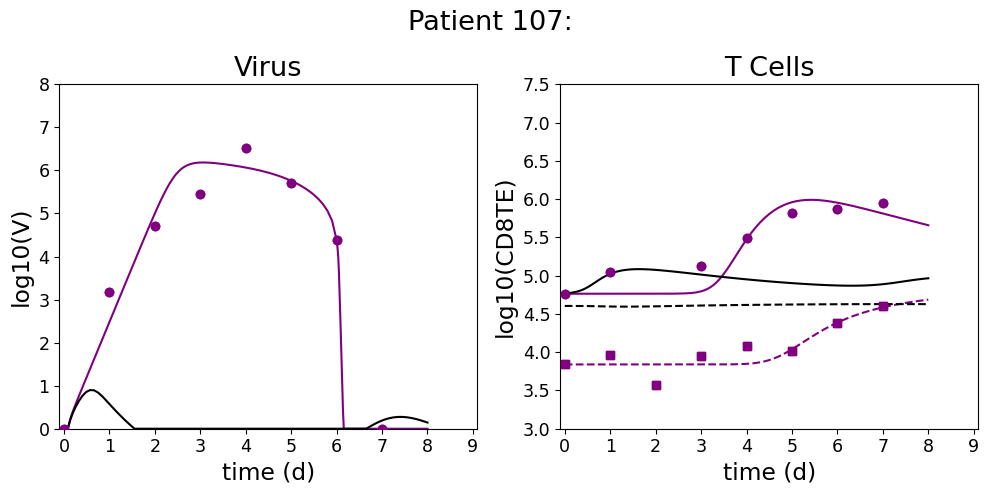

No parameters to optimize
No parameters to optimize


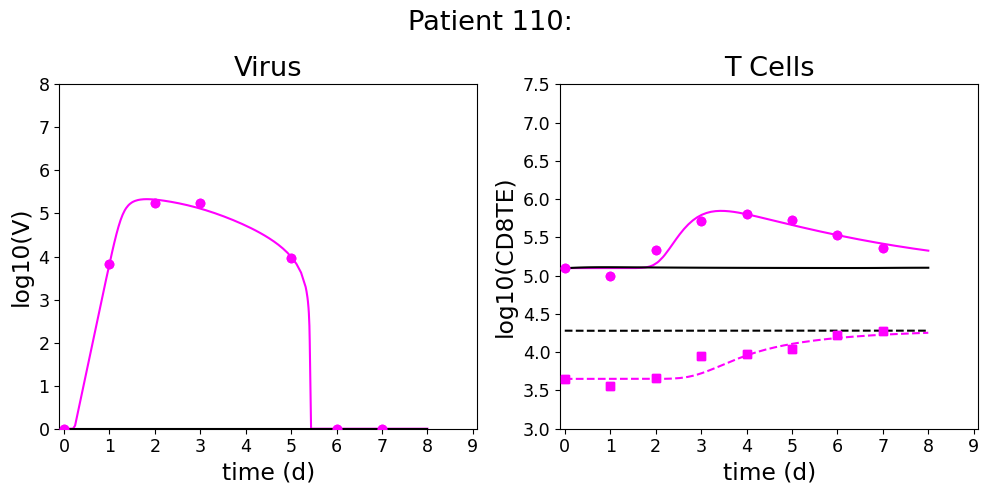

No parameters to optimize
No parameters to optimize


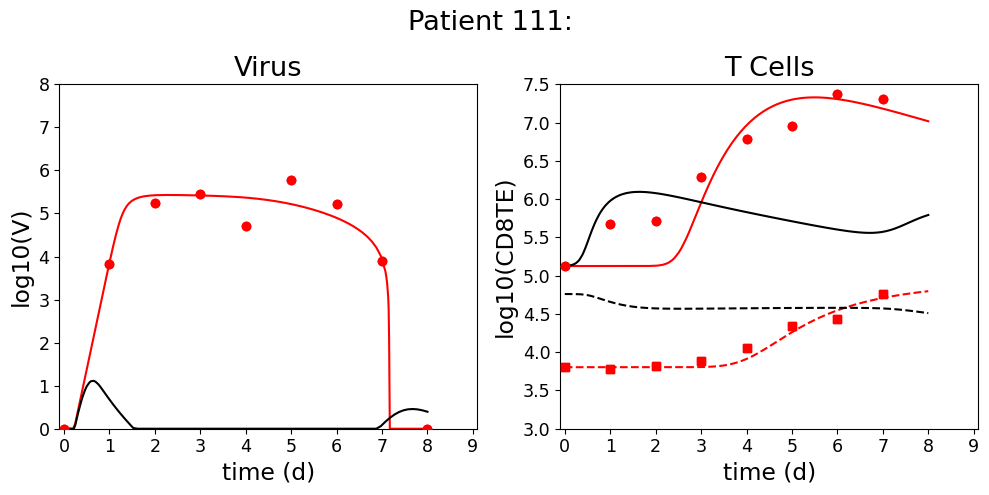

No parameters to optimize
No parameters to optimize


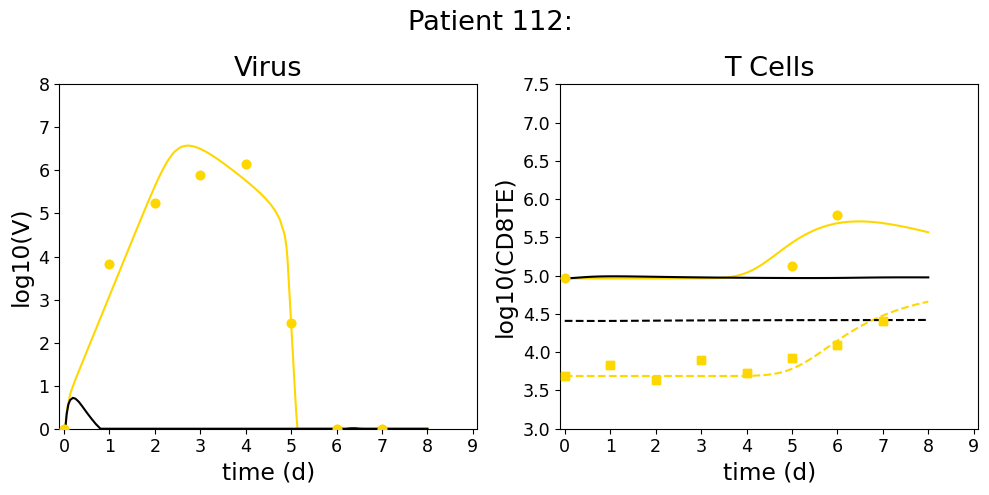

No parameters to optimize
No parameters to optimize


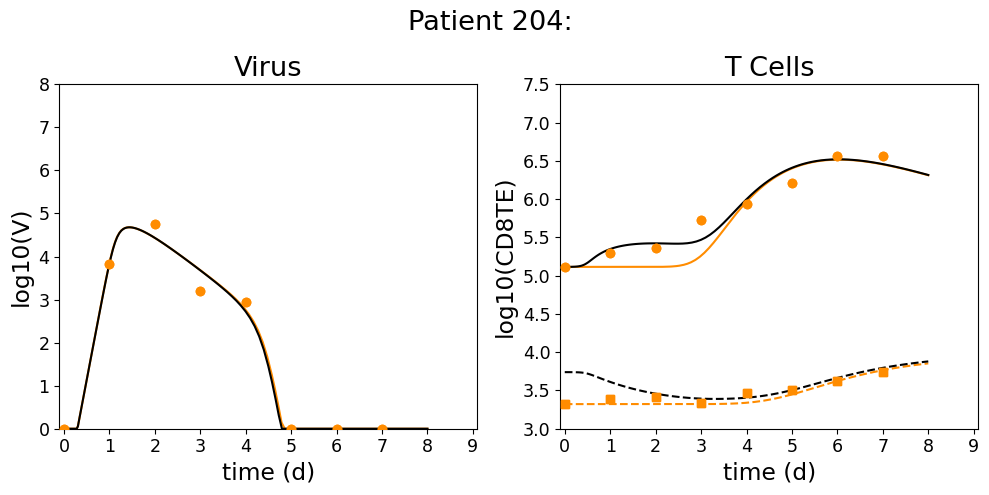

No parameters to optimize
No parameters to optimize


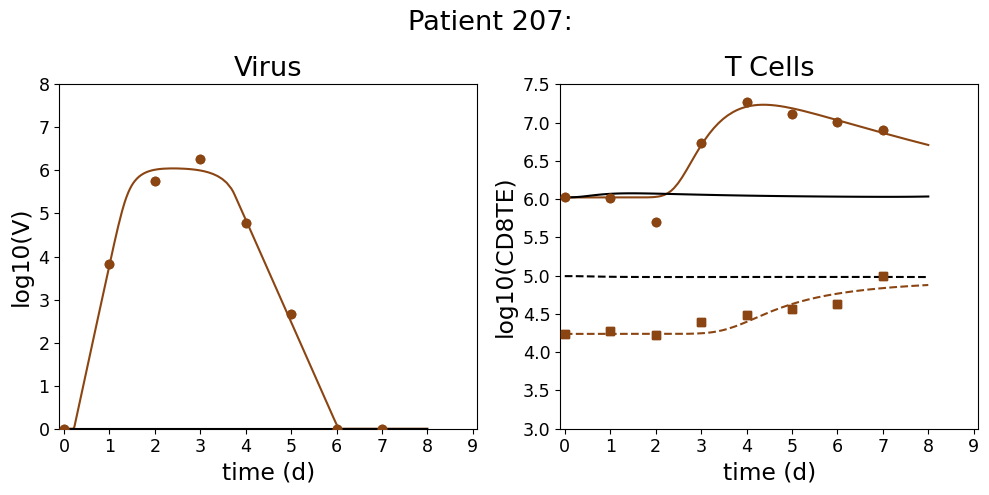

No parameters to optimize
No parameters to optimize


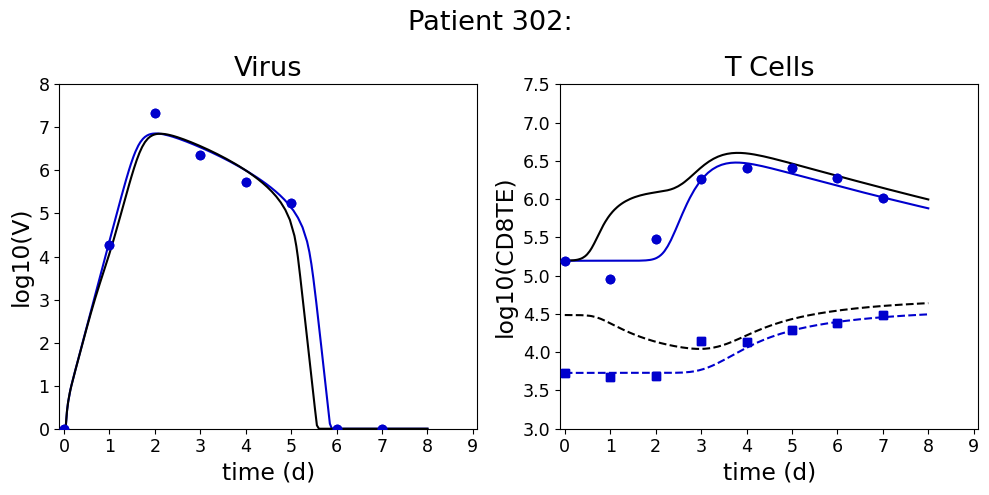

No parameters to optimize
No parameters to optimize


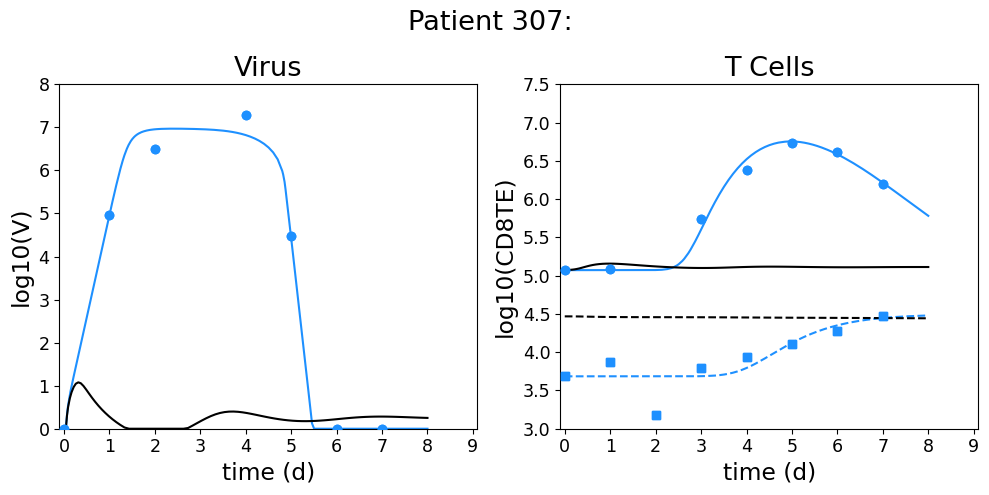

No parameters to optimize
No parameters to optimize


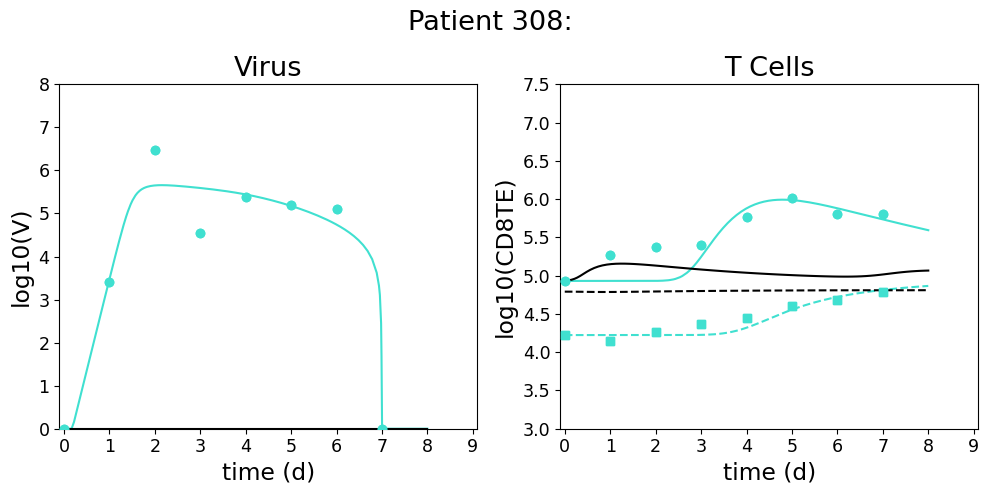

No parameters to optimize
No parameters to optimize


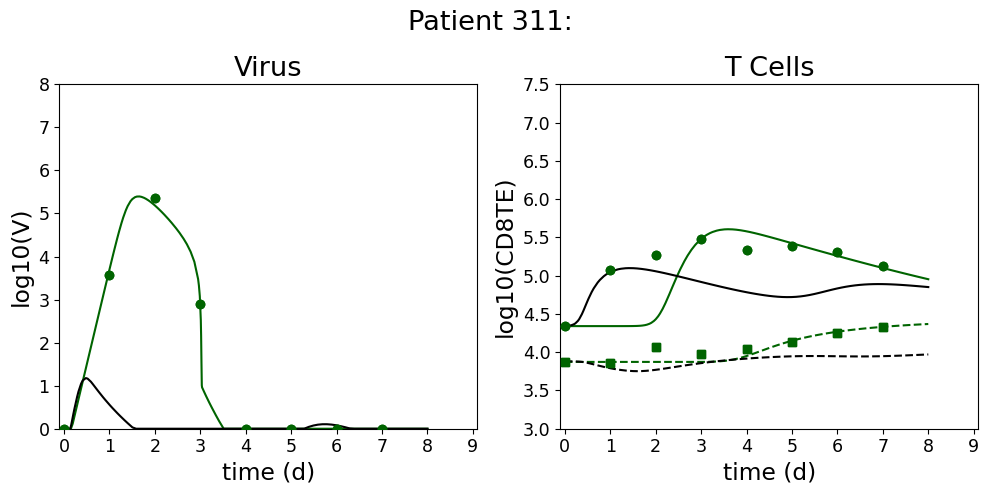

No parameters to optimize
No parameters to optimize


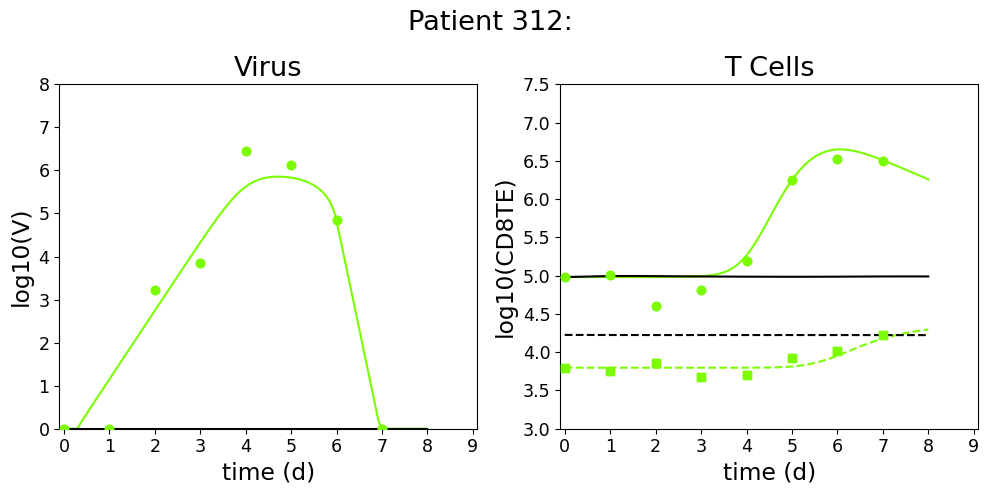

In [171]:
# Rahil Setup - Rechallenge Forecast
shedders = [103, 107, 110, 111, 112, 204, 207, 302, 307, 308, 311, 312]
targets = ['Population']
ids = targets + shedders
subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, 'sol_key': 0, 'ylims': [0, 8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'ylims': [0, 8]},
    #{'title': 'Infected Cells', 'data_key': None, 'sol_key': 2, 'ylims': [0, 8]},
    {'title': 'Virus', 'data_key': 'V', 'sol_key': 3,'ylims': [0,8]},
    {'title': 'T Cells', 'data_key': ['CD8TE','CD8TM'], 'sol_key': [4, 5], 'ylims': [3,7.5]}, 
    #{'title': 'T Memory', 'data_key': 'CD8TM', 'sol_key': 5, 'ylims': [3,5.25]}, 
]

n_Z = 13
# Import data
df = pd.read_excel("../Data/Rahil_2020/Table8_Healed.xlsx", sheet_name='112Cens')
df_Rahil = df[['VOLUNTEER', 'DAY', 'V', 'IFNG', 'CD8TE', 'CD8TM']]
#df_Rahil = df_Rahil.loc[df_Rahil['DAY'] < 9]
# LCT Model, Viral Parameters (p + 8 others)
states = [
    {'label': 'T', 'initial_value': 4E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TM', 'initial_value': 0.0, 'sse': False},
]

for i in range(1, n_Z + 1):
    states.append({'label': f'Z{i}', 'initial_value': 0.0, 'sse': False})
states.append({'label': 'CD8T_Tot', 'initial_value': 0.0, 'sse': False})

parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2.1E4, u_lim=1.7E5, method='file', space='log10'),
    M0=Parameter(name='M0', val=1E4, l_lim=2E3, u_lim=3E4, method='file', space='log10'),
    ME=Parameter(name='ME', val=0, l_lim=2E4, u_lim=3E5, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=8E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-6, u_lim=1E-3, method='file', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=1, l_lim=0.05, u_lim=10, method='file', space='normal'), 
    c=Parameter(name='c', val=10, l_lim=5.0, u_lim=500, method='file', space='log10'), 
    delta=Parameter(name='delta', val=3, l_lim=0.05, u_lim=5, method='file', space='log10'),
    xi=Parameter(name='xi', val=0.0, l_lim=0.05, u_lim=10, method='file', space='log10'), 
    a=Parameter(name='a', val=0.0, l_lim=1.0, u_lim=10, method='file', space='normal'), 
    d_E=Parameter(name='d_E', val=0.5, l_lim=0.4, u_lim=2, method='file', space='normal'),
    delta_E=Parameter(name='delta_E', val=.75, l_lim=0.5, u_lim=10, method='file', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=1.9E4, l_lim=1E2, u_lim=1E5, method='file', space='log10'),
    zeta=Parameter(name='zeta', val=0.07, l_lim=5E-4, u_lim=1E-1, method='file', space='log10'),
    eta=Parameter(name='eta', val=0, l_lim=1, u_lim=100, method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=2.5, l_lim=0.25, u_lim=2, method='file', space='normal'),
)

parameters_rechallenge = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2E4, u_lim=1.2E6, method='file', space='log10'),
    M0=Parameter(name='M0', val=1E3, l_lim=2E4, u_lim=3E5, method='file', space='log10'),
    ME=Parameter(name='ME', val=6.6E3, l_lim=2E4, u_lim=3E5, method='file', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=8E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=5E-7, u_lim=5E-2, method='file', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=4.184819, l_lim=1, u_lim=10, method='file', space='normal'), 
    c=Parameter(name='c', val=100, l_lim=1.0, u_lim=1000, method='file', space='log10'), 
    delta=Parameter(name='delta', val=3, l_lim=0.1, u_lim=2.5, method='file', space='normal'),
    xi=Parameter(name='xi', val=0.0, l_lim=1E-2, u_lim=10, method='file', space='log10'), 
    a=Parameter(name='a', val=0, l_lim=0.1, u_lim=15, method='file', space='normal'), 
    d_E=Parameter(name='d_E', val=0.532, l_lim=0.5, u_lim=3, method='file', space='normal'),
    delta_E=Parameter(name='delta_E', val=7.598, l_lim=1E-1, u_lim=15, method='file', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=36696, l_lim=1E2, u_lim=1E5, method='file', space='log10'),
    zeta=Parameter(name='zeta', val=0.7, l_lim=1E-4, u_lim=1, method='file', space='log10'),
    eta=Parameter(name='eta', val=75.77, l_lim=10, u_lim=2500, method='fixed', space='log10'),
    K_I1=Parameter(name='K_I1', val=13541, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=2.5, l_lim=0.5, u_lim=3, method='file', space='normal'),
)

t_span = (0, 8)
patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
patients_rechallenge = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters_rechallenge, states=states, parameter_file='Rechallenge.xlsx')
for target in shedders:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=True, path='Memorytest2')
    results_rechallenge = patients_rechallenge.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=True, path='Memorytest2')
    patient_color = color_mapping.get(target, 'black') 
    plot_per_patient_both_sets(
        results=results,
        results_rechallenge=results_rechallenge,
        subplot_config=subplot_configuration,
        t_span=[0,9],
        figsize=(10,5),
        patient_color=patient_color,
        save=True
    )

ID 37 not found in parameter file.
ID 38 not found in parameter file.
ID 39 not found in parameter file.
ID 40 not found in parameter file.
ID 41 not found in parameter file.
ID 42 not found in parameter file.
ID 43 not found in parameter file.
ID 44 not found in parameter file.
37 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 1.5386832397885937
differential_evolution step 2: f(x)= 1.325423692283091
differential_evolution step 3: f(x)= 1.325423692283091
differential_evolution step 4: f(x)= 1.3064764255226382
differential_evolution step 5: f(x)= 1.253577702968187
differential_evolution step 6: f(x)= 1.253577702968187
differential_evolution step 7: f(x)= 1.253577702968187
differential_evolution step 8: f(x)= 1.253577702968187
differential_evolution step 9: f(x)= 1.249026420593444
differential_evolution step 10: f(x)= 1.2450734487869954
differential_evolution step 11: f(x)= 1.2450734487869954
differential_evolution step 12: f(x)= 1.2436536256707322
diffe

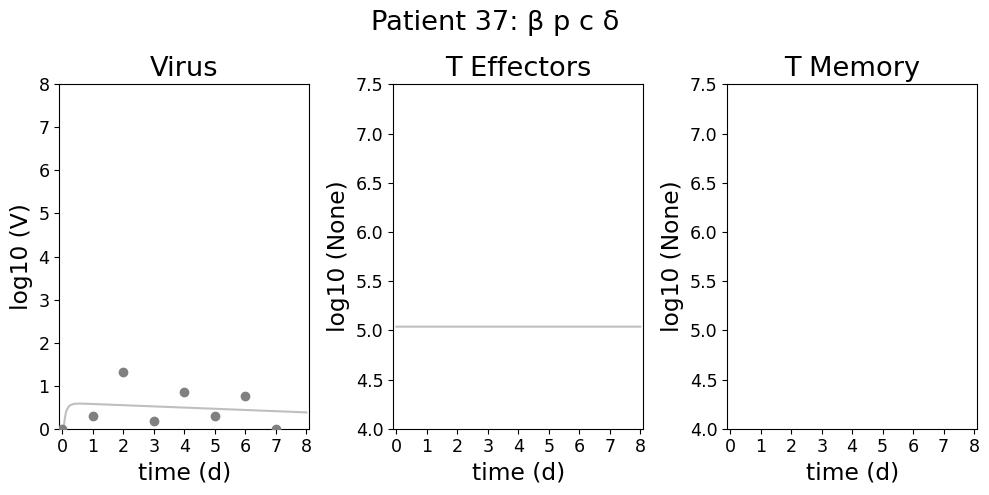

38 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 6.77888402970439
differential_evolution step 2: f(x)= 5.697895911719836
differential_evolution step 3: f(x)= 5.697895911719836
differential_evolution step 4: f(x)= 5.697895911719836
differential_evolution step 5: f(x)= 5.6976720960246725
differential_evolution step 6: f(x)= 5.6976720960246725
differential_evolution step 7: f(x)= 5.678962426495066
differential_evolution step 8: f(x)= 5.5897975856291415
differential_evolution step 9: f(x)= 5.5897975856291415
differential_evolution step 10: f(x)= 5.5595708914837285
differential_evolution step 11: f(x)= 5.5595708914837285
differential_evolution step 12: f(x)= 5.5595708914837285
differential_evolution step 13: f(x)= 5.5595708914837285
differential_evolution step 14: f(x)= 5.5595708914837285
differential_evolution step 15: f(x)= 5.5595708914837285
differential_evolution step 16: f(x)= 5.5595708914837285
differential_evolution step 17: f(x)= 5.5595708914837285

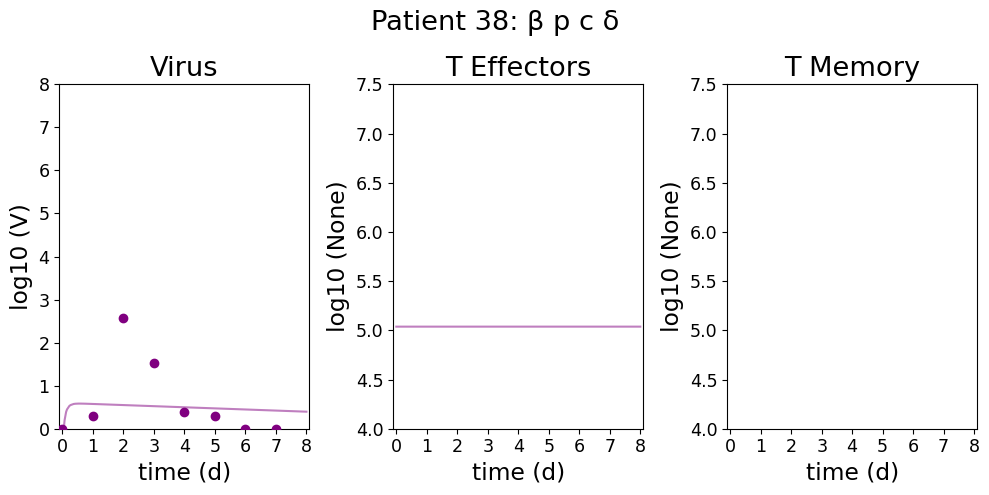

39 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 1.8165120634574203
differential_evolution step 2: f(x)= 1.597961216021143
differential_evolution step 3: f(x)= 1.597961216021143
differential_evolution step 4: f(x)= 1.5851311894982625
differential_evolution step 5: f(x)= 1.5785724379465471
differential_evolution step 6: f(x)= 1.5785724379465471
differential_evolution step 7: f(x)= 1.574357492403619
differential_evolution step 8: f(x)= 1.5503302608380136
differential_evolution step 9: f(x)= 1.5493042652309232
differential_evolution step 10: f(x)= 1.5426846935595775
differential_evolution step 11: f(x)= 1.5413705325553648
differential_evolution step 12: f(x)= 1.540080428588533
differential_evolution step 13: f(x)= 1.540080428588533
differential_evolution step 14: f(x)= 1.540080428588533
differential_evolution step 15: f(x)= 1.540080428588533
differential_evolution step 16: f(x)= 1.540080428588533
differential_evolution step 17: f(x)= 1.540080428588533
di

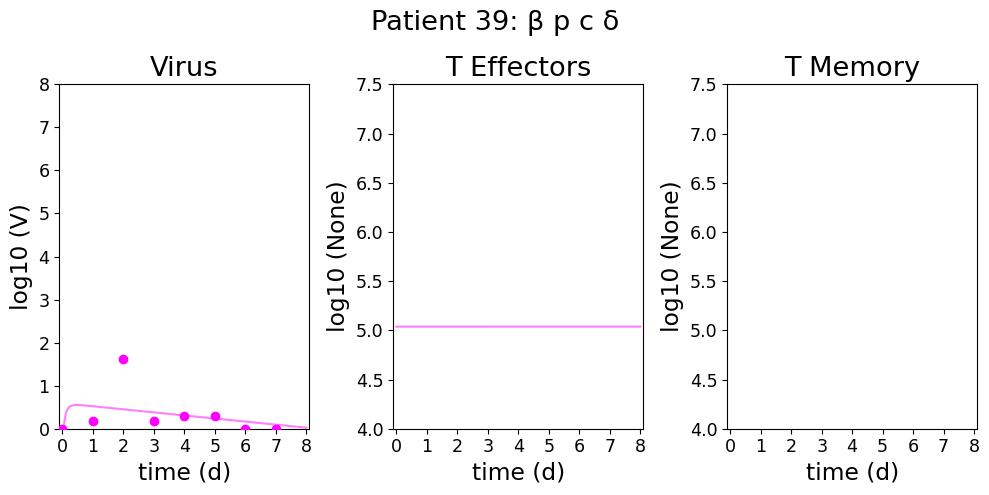

40 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 1.1014970701194955
differential_evolution step 2: f(x)= 1.1014970701194955
differential_evolution step 3: f(x)= 0.9785274952593279
differential_evolution step 4: f(x)= 0.9785274952593279
differential_evolution step 5: f(x)= 0.9785274952593279
differential_evolution step 6: f(x)= 0.9785274952593279
differential_evolution step 7: f(x)= 0.9785274952593279
differential_evolution step 8: f(x)= 0.9784436138409358
differential_evolution step 9: f(x)= 0.9784436138409358
differential_evolution step 10: f(x)= 0.9704354935402271
differential_evolution step 11: f(x)= 0.9704354935402271
differential_evolution step 12: f(x)= 0.9702730514623001
differential_evolution step 13: f(x)= 0.9702730514623001
differential_evolution step 14: f(x)= 0.9702730514623001
differential_evolution step 15: f(x)= 0.9702730514623001
differential_evolution step 16: f(x)= 0.9702730514623001
differential_evolution step 17: f(x)= 0.9702730514

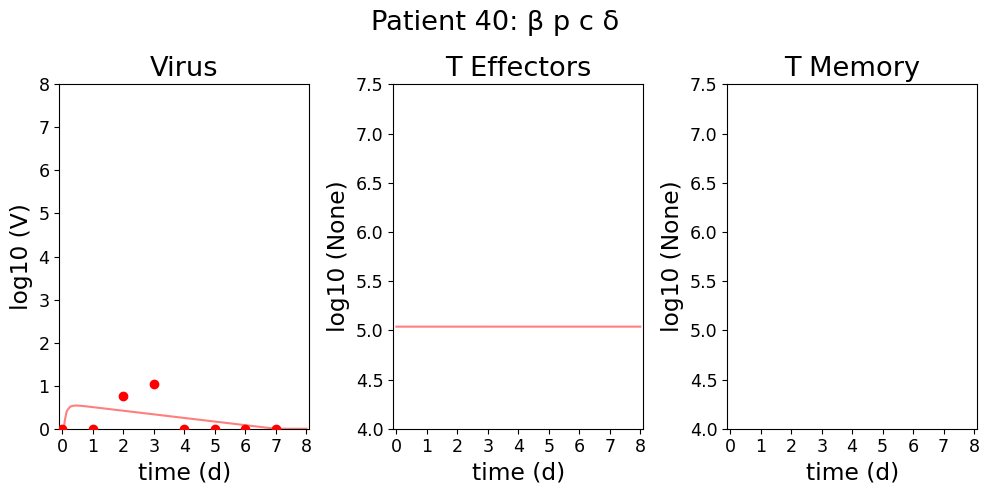

41 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 2.2134617369583465
differential_evolution step 2: f(x)= 1.9905736407971388
differential_evolution step 3: f(x)= 1.8613088787949323
differential_evolution step 4: f(x)= 1.8099239700618883
differential_evolution step 5: f(x)= 1.7157613760492938
differential_evolution step 6: f(x)= 1.7157613760492938
differential_evolution step 7: f(x)= 1.7157613760492938
differential_evolution step 8: f(x)= 1.7157613760492938
differential_evolution step 9: f(x)= 1.7157613760492938
differential_evolution step 10: f(x)= 1.7157613760492938
differential_evolution step 11: f(x)= 1.7157613760492938
differential_evolution step 12: f(x)= 1.7157613760492938
differential_evolution step 13: f(x)= 1.7058648381572585
differential_evolution step 14: f(x)= 1.7024355516904797
differential_evolution step 15: f(x)= 1.7024355516904797
differential_evolution step 16: f(x)= 1.700654545658353
differential_evolution step 17: f(x)= 1.70042753432

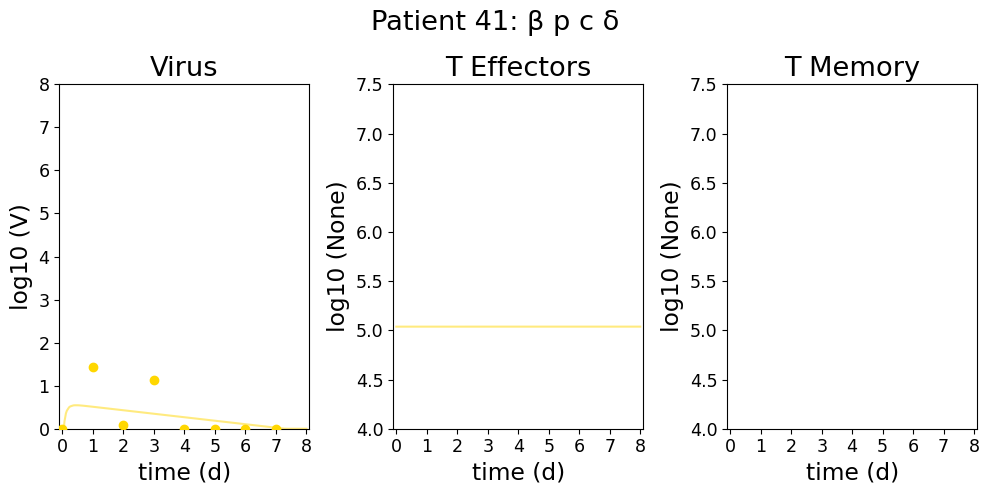

42 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 1.7420867875726571
differential_evolution step 2: f(x)= 1.7420867875726571
differential_evolution step 3: f(x)= 1.629374866932987
differential_evolution step 4: f(x)= 1.5151868424212687
differential_evolution step 5: f(x)= 1.3973799775061464
differential_evolution step 6: f(x)= 1.3973799775061464
differential_evolution step 7: f(x)= 1.3917350076449018
differential_evolution step 8: f(x)= 1.3917350076449018
differential_evolution step 9: f(x)= 1.3817548286086008
differential_evolution step 10: f(x)= 1.3799891415442564
differential_evolution step 11: f(x)= 1.3799891415442564
differential_evolution step 12: f(x)= 1.3799891415442564
differential_evolution step 13: f(x)= 1.3669069619775074
differential_evolution step 14: f(x)= 1.3669069619775074
differential_evolution step 15: f(x)= 1.3669069619775074
differential_evolution step 16: f(x)= 1.3669069619775074
differential_evolution step 17: f(x)= 1.36690696197

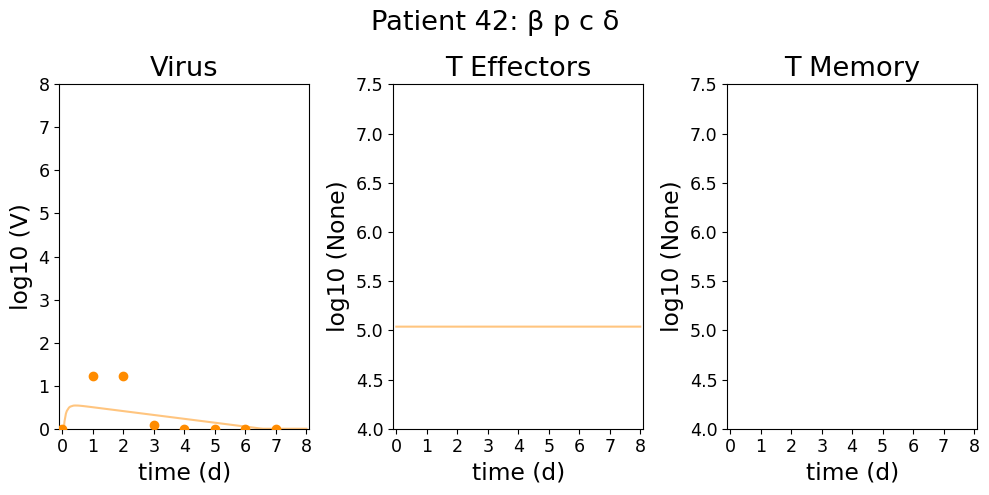

43 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 1.5276482736776589
differential_evolution step 2: f(x)= 1.5088554421096259
differential_evolution step 3: f(x)= 1.469007420626508
differential_evolution step 4: f(x)= 1.4573020391151466
differential_evolution step 5: f(x)= 1.4540350799955242
differential_evolution step 6: f(x)= 1.4449463299084853
differential_evolution step 7: f(x)= 1.4439810608169932
differential_evolution step 8: f(x)= 1.441699246890511
differential_evolution step 9: f(x)= 1.4396400060523689
differential_evolution step 10: f(x)= 1.4374479628944306
differential_evolution step 11: f(x)= 1.4374479628944306
differential_evolution step 12: f(x)= 1.4374479628944306
differential_evolution step 13: f(x)= 1.4374479628944306
differential_evolution step 14: f(x)= 1.4363992019751037
differential_evolution step 15: f(x)= 1.435660490543918
differential_evolution step 16: f(x)= 1.435660490543918
differential_evolution step 17: f(x)= 1.43566049054391

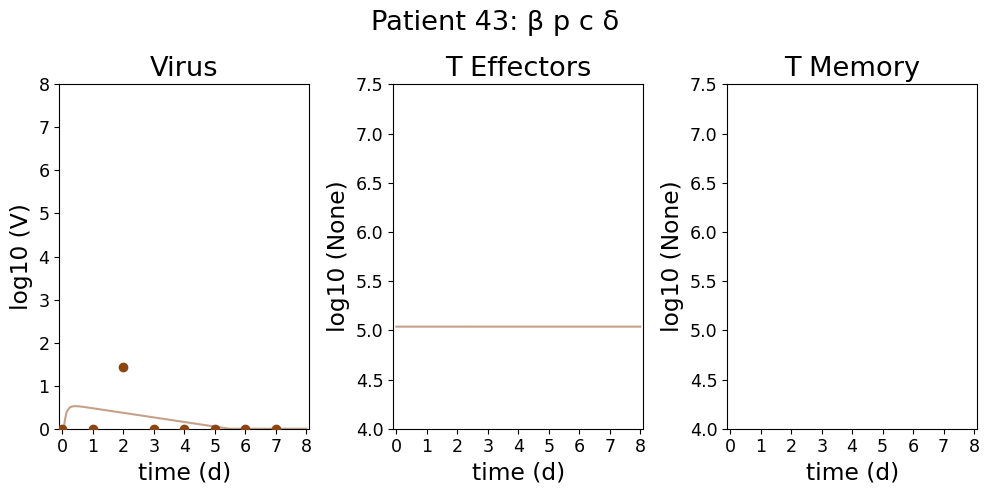

44 Differential Evolution with 25 generations.
differential_evolution step 1: f(x)= 1.0618360916015548
differential_evolution step 2: f(x)= 1.015150491029815
differential_evolution step 3: f(x)= 1.0052162103213127
differential_evolution step 4: f(x)= 0.9993947729329933
differential_evolution step 5: f(x)= 0.9943243587433007
differential_evolution step 6: f(x)= 0.9943243587433007
differential_evolution step 7: f(x)= 0.9943243587433007
differential_evolution step 8: f(x)= 0.9943243587433007
differential_evolution step 9: f(x)= 0.9943243587433007
differential_evolution step 10: f(x)= 0.9935804255809932
differential_evolution step 11: f(x)= 0.9935804255809932
differential_evolution step 12: f(x)= 0.9934741426370003
differential_evolution step 13: f(x)= 0.9934741426370003
differential_evolution step 14: f(x)= 0.9932482896957796
differential_evolution step 15: f(x)= 0.9932482896957796
differential_evolution step 16: f(x)= 0.9918880931403423
differential_evolution step 17: f(x)= 0.99188809314

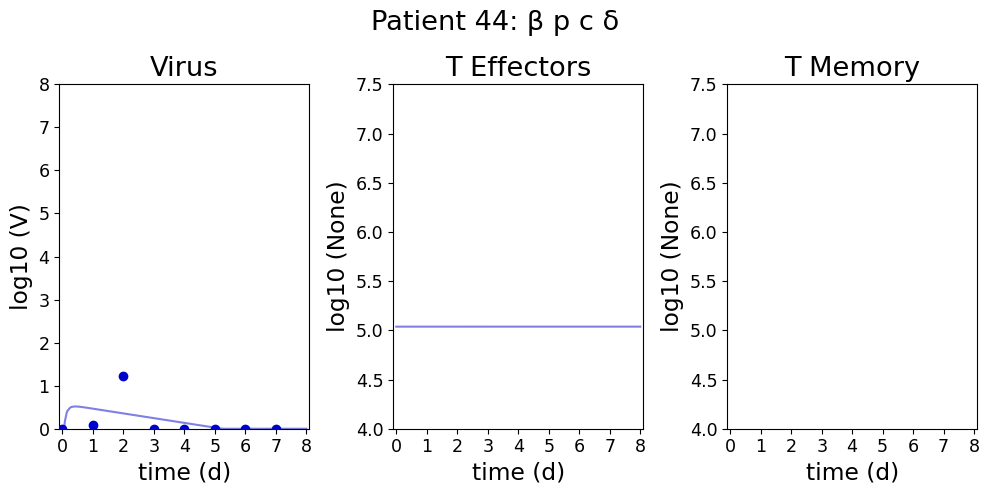

In [15]:
# Canini
subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, 'sol_key': 0, 'ylims': [0, 8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1, 'ylims': [0, 8]},
    #{'title': 'Infected Cells', 'data_key': None, 'sol_key': 2, 'ylims': [0, 8]},
    {'title': 'Virus', 'data_key': 'V', 'sol_key': 3,'ylims': [0,8]},
    {'title': 'T Effectors', 'data_key': None, 'sol_key': 4, 'ylims': [4,7.5]}, 
    #{'title': 'TEM', 'data_key': None, 'sol_key': 6, 'ylims': [2,7.5]},
    {'title': 'T Memory', 'data_key': None, 'sol_key': 5, 'ylims': [4,7.5]}, 
]

n_Z = 13
df = pd.read_excel("../Data/Canini.xlsx")
df_Canini = df[['VOLUNTEER', 'DAY', 'V', 'RS', 'SS', 'TSS']]

states = [
    {'label': 'T', 'initial_value': 4E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8TE', 'initial_value': 0.0, 'sse': False},
    {'label': 'CD8TM', 'initial_value': 0.0, 'sse': False},
]

for i in range(1, n_Z + 1):
    states.append({'label': f'Z{i}', 'initial_value': 0.0, 'sse': False})
states.append({'label': 'CD8T_Tot', 'initial_value': 0.0, 'sse': False})

parameters = Parameters(
    E0=Parameter(name='E0', val=109000, l_lim=2.1E4, u_lim=1.7E5, method='fixed', space='log10'),
    M0=Parameter(name='M0', val=9000, l_lim=2E3, u_lim=3E4, method='fixed', space='log10'),
    ME=Parameter(name='ME', val=0, l_lim=2E4, u_lim=3E5, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=8E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=6.69E-05, l_lim=1E-6, u_lim=1E-3, method='fit', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=1.6, l_lim=0.05, u_lim=10, method='fit', space='normal'), 
    c=Parameter(name='c', val=100, l_lim=5.0, u_lim=500, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=1.12, l_lim=0.05, u_lim=5, method='fit', space='log10'),
    xi=Parameter(name='xi', val=0.254, l_lim=0.05, u_lim=10, method='fixed', space='log10'), 
    a=Parameter(name='a', val=6.89, l_lim=1.0, u_lim=10, method='fixed', space='normal'), 
    d_E=Parameter(name='d_E', val=0.49, l_lim=0.4, u_lim=2, method='fixed', space='normal'),
    delta_E=Parameter(name='delta_E', val=.5, l_lim=0.5, u_lim=10, method='fixed', space='log10'),
    K_delta_E=Parameter(name='K_delta_E', val=99000, l_lim=1E2, u_lim=1E5, method='fixed', space='log10'),
    zeta=Parameter(name='zeta', val=0.006, l_lim=5E-4, u_lim=1E-1, method='fixed', space='log10'),
    eta=Parameter(name='eta', val=0, l_lim=1, u_lim=100, method='fixed', space='log10'), 
    K_I1=Parameter(name='K_I1', val=10000, l_lim=1E2, u_lim=1E6, method='fixed', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=1.21, l_lim=0.25, u_lim=2, method='fixed', space='normal'),
)

t_span = (0, 8)

shedders = list(range(1,13))
shedders = list(range(13,25))
shedders = list(range(25,37))
shedders = list(range(37,45))
targets = ['Population']
ids = targets + shedders
patient_color_names = [
'black',
'gray',
'purple',
'magenta',
'red',
'gold',
'darkorange',
'saddlebrown',
'mediumblue',
'dodgerblue',
'turquoise',
'darkgreen',
'lawngreen']
color_mapping = {id_: color for id_, color in zip(ids, patient_color_names)}

patients = Patients(ids=ids, df=df_Canini, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in shedders:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=25, verbose=True, path='Canini')
    
    patient_color = color_mapping.get(target, 'black') 
    plot(results, subplot_configuration, t_span, figsize=(10,5), patient_color=patient_color)

In [5]:
def plot_Murine(results, subplot_config, shedders):
    t_span = [0, 12]
    x_ticks = np.arange(t_span[0], t_span[-1] + 1, 1)
    n_subplots = len(subplot_config)
    
    if n_subplots <= 3:
        n_rows, n_cols = 1, n_subplots
    else:
        n_rows, n_cols = int(np.ceil(np.sqrt(n_subplots))), int(np.ceil(n_subplots / np.sqrt(n_subplots)))
    
    base_font_size = 14

    title_font_size = base_font_size * 1.4
    label_font_size = base_font_size * 1.2
    tick_font_size = base_font_size * 0.9

    fit_params_set = set()

    for result, patient in results:
        # Get only the parameters that were fit
        fit_parameters = [param_name for param_name, param in patient.parameters._parameters.items() if param.method == 'fit']
        fit_params_set.update(fit_parameters)

        fig, axs = plt.subplots(n_rows, n_cols, figsize=(10, 5), squeeze=False)
        axs_flat = axs.flatten()

        for i, config in enumerate(subplot_config):
            ax = axs_flat[i]
            ax.set_title(config['title'], fontsize=title_font_size)
            if config['data_key']:
                volunteer_data = patient.df[patient.df['VOLUNTEER'].isin(shedders)]
                if config['data_key']=='V' or config['data_key']=='CD8T_Tot':
                    volunteer_data[config['data_key']] = np.log10(np.where(volunteer_data[config['data_key']] < 1, 1, volunteer_data[config['data_key']]))
                group_by_day = volunteer_data.groupby('DAY')[config['data_key']]
                mean_values = group_by_day.mean()
                std_values = group_by_day.std()

                ax.scatter(mean_values.index, mean_values, edgecolor='black',
                            facecolor='white', marker='s', label='Mean', zorder=25, s=75)
                ax.errorbar(mean_values.index, mean_values, yerr=std_values, fmt='none',
                            ecolor='black', capsize=5, label='Std Dev', zorder=20)

            if config['sol_key'] is not None and patient.sol:
                sol_t = patient.sol.t
                if isinstance(config['sol_key'], list):
                    for i, key in enumerate(config['sol_key']):
                        sol_y_raw = patient.sol.y[key]
                        sol_y = np.log10(np.where(sol_y_raw < 1, 1, sol_y_raw))
                        if i == 0:
                            ax.plot(sol_t, sol_y, color=patient.color, alpha=0.5)
                        else:
                            ax.plot(sol_t, sol_y, color=plt.cm.tab10(i), alpha=0.5)
                else:
                    sol_y_raw = patient.sol.y[config['sol_key']]
                    sol_y = np.log10(np.where(sol_y_raw < 1, 1, sol_y_raw))
                    ax.plot(sol_t, sol_y, color=patient.color, alpha=0.5)

            if config['ylims']:
                ax.set_ylim(config['ylims'])

            ax.set_xticks(x_ticks)
            ax.set_xlim([t_span[0] - 0.1, t_span[-1] + 0.1])
            ax.set_xlabel('time (d)', fontsize=label_font_size)
            ax.set_ylabel(f'log10 ({config["data_key"]})', fontsize=label_font_size)
            ax.tick_params(axis='both', which='major', labelsize=tick_font_size)

    plt.tight_layout()
    plt.show()

# Myers Setup
shedders = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
targets = ['Murine']
ids = targets + shedders
subplot_configuration = [
    #{'title': 'Target Cells', 'data_key': None, 'sol_key': 0,  'ylims': [1, 5E8]},
    #{'title': 'Eclipse Cells', 'data_key': None, 'sol_key': 1,  'ylims': [1, 5E8]},
    #{'title': 'Infected Cells', 'data_key': None, 'sol_key': 2,'ylims': [1, 5E8]},
    {'title': 'Virus', 'data_key': 'V', 'sol_key': 3, 'ylims': [0,8]},
    {'title': 'CD8 T Cells', 'data_key': 'CD8T_Tot', 'sol_key': [4, 5, 20], 'ylims': [5.5,6.5]}, #Effector, Memory, Total
]

n_Z = 13
t_span = (0.0, 12.0)
# Import data
df = pd.read_excel("../Data/Murine Data.xlsx", sheet_name='Dynamics')
df_Myers = df[['VOLUNTEER', 'DAY', 'V', 'IFNG', 'CD8T_Tot']]

states = [
    {'label': 'T', 'initial_value': 1E7, 'sse': False},
    {'label': 'I1', 'initial_value': 75.0, 'sse': False},
    {'label': 'I2', 'initial_value': 0.0, 'sse': False},
    {'label': 'V', 'initial_value': 0.0, 'sse': True},
    {'label': 'CD8T_E', 'initial_value': 0.0, 'sse': False},
    {'label': 'CD8T_Mem', 'initial_value': 0.0, 'sse': False},
]

for i in range(1, n_Z + 1):
    states.append({'label': f'Z{i}', 'initial_value': 0.0, 'sse': False})
states.append({'label': 'CD8T_Tot', 'initial_value': 0.0, 'sse': True})

parameters = Parameters(
    E0=Parameter(name='E0', val=4.2E5, l_lim=2E4, u_lim=1.2E6, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=1E7, l_lim=1E7, u_lim=4.001E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=6.2E-5, l_lim=5E-7, u_lim=5E-2, method='fixed', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=1, l_lim=1, u_lim=10, method='fixed', space='normal'), 
    c=Parameter(name='c', val=9.4, l_lim=10.0, u_lim=1E3, method='fixed', space='log10'), 
    delta=Parameter(name='delta', val=0.24, l_lim=0.4, u_lim=2.5, method='fixed', space='normal'),
    xi=Parameter(name='xi', val=2.1, l_lim=1E-2, u_lim=10.0, method='fixed', space='normal'), 
    a=Parameter(name='a', val=2.3, l_lim=1.0, u_lim=15, method='fixed', space='normal'), 
    d_E=Parameter(name='d_E', val=1.0, l_lim=0.5, u_lim=2.5, method='fixed', space='normal'),
    delta_E=Parameter(name='delta_E', val=1.9, l_lim=1E-1, u_lim=10, method='fixed', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=434, l_lim=1E1, u_lim=1E5, method='fixed', space='log10'),
    zeta=Parameter(name='zeta', val=2.2E-1, l_lim=1E-2, u_lim=1, method='fixed', space='normal'),
    tau_memory=Parameter(name='tau_memory', val=3.5, l_lim=1.0, u_lim=5, method='fixed', space='normal')
)

patients = Patients(ids=ids, df=df_Myers, t_span=t_span, parameters=parameters, states=states)
for target in targets:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=10, verbose=True, path='Murine')

    plot_Murine(results, subplot_configuration, shedders)

No parameters loaded: No file specified. Add parameter_file= to Patients initialization call.
No parameters to optimize
Error solving patient Murine: 'Parameters' object has no attribute 'eta'


AttributeError: 'NoneType' object has no attribute 't'

In [6]:
# Myers Setup

parameters = Parameters(
    E0=Parameter(name='E0', val=4.2E5, l_lim=2E4, u_lim=1.2E6, method='fixed', space='log10'),
    T0=Parameter(name='T0', val=1E7, l_lim=1E7, u_lim=4.001E7, method='fixed', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=6.2E-5, l_lim=5E-7, u_lim=5E-2, method='fixed', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=1, l_lim=1, u_lim=10, method='fixed', space='normal'), 
    c=Parameter(name='c', val=9.4, l_lim=10.0, u_lim=1E3, method='fixed', space='log10'), 
    delta=Parameter(name='delta', val=0.24, l_lim=0.4, u_lim=2.5, method='fixed', space='normal'),
    xi=Parameter(name='xi', val=2.1, l_lim=1E-2, u_lim=10.0, method='fit', space='normal'), 
    a=Parameter(name='a', val=2.3, l_lim=1.0, u_lim=15, method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=1.0, l_lim=0.5, u_lim=2.5, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=1.9, l_lim=1E-1, u_lim=10, method='fixed', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=434, l_lim=1E1, u_lim=1E5, method='fixed', space='log10'),
    zeta=Parameter(name='zeta', val=2.2E-1, l_lim=1E-2, u_lim=1, method='fit', space='normal'),
    tau_memory=Parameter(name='tau_memory', val=3.5, l_lim=1.0, u_lim=5, method='fixed', space='normal')
)

patients = Patients(ids=ids, df=df_Myers, t_span=t_span, parameters=parameters, states=states)
for target in targets:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=10, verbose=True, path='Murine')

    plot_Murine(results, subplot_configuration, shedders)

No parameters loaded: No file specified. Add parameter_file= to Patients initialization call.
Murine Differential Evolution with 10 generations.
Error solving patient Murine: 'Parameters' object has no attribute 'M0'


AttributeError: 'NoneType' object has no attribute 't'

Population Differential Evolution with 250 generations.


C:\Users\jorda\AppData\Local\Temp\ipykernel_17240\3087843375.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pid_df['VOLUNTEER'] = 'Population'


differential_evolution step 1: f(x)= 688.302353345205
differential_evolution step 2: f(x)= 665.2826431869744
differential_evolution step 3: f(x)= 665.2826431869744
differential_evolution step 4: f(x)= 641.5113967228122
differential_evolution step 5: f(x)= 641.5113967228122
differential_evolution step 6: f(x)= 641.5113967228122
differential_evolution step 7: f(x)= 630.7497459295631
differential_evolution step 8: f(x)= 612.3888953004322
differential_evolution step 9: f(x)= 603.4006209160367
differential_evolution step 10: f(x)= 603.4006209160367
differential_evolution step 11: f(x)= 599.99232794388
differential_evolution step 12: f(x)= 599.8538568661661
differential_evolution step 13: f(x)= 599.8538568661661
differential_evolution step 14: f(x)= 593.4459081336108
differential_evolution step 15: f(x)= 593.4459081336108
differential_evolution step 16: f(x)= 593.4459081336108
differential_evolution step 17: f(x)= 593.4459081336108
differential_evolution step 18: f(x)= 592.100166708294
diffe

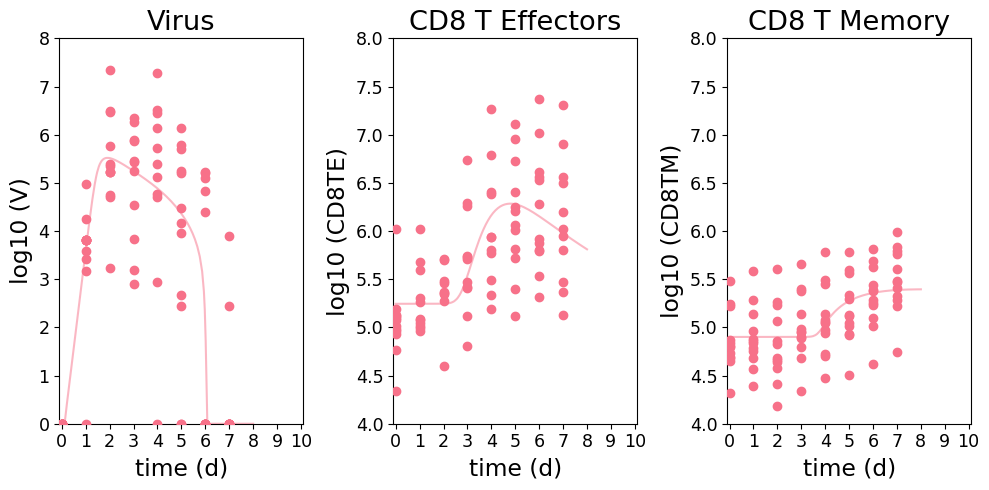

In [29]:
parameters = Parameters(
    E0=Parameter(name='E0', val=3.43E5, l_lim=2E4, u_lim=1.2E6, method='fit', space='log10'),
    M0=Parameter(name='M0', val=3.43E5, l_lim=2E4, u_lim=3E5, method='fit', space='log10'),
    T0=Parameter(name='T0', val=4E7, l_lim=1E7, u_lim=8E7, method='fit', space='log10'),
    I10=Parameter(name='I10', val=75, l_lim=1, u_lim=1E3, method='fixed', space='log10'), 
    beta=Parameter(name='beta', val=1.0888E-4, l_lim=1E-6, u_lim=1E-3, method='file', space='log10'), 
    k=Parameter(name='k', val=4.0, l_lim=1.0, u_lim=10.0, method='fixed', space='log10'), 
    p=Parameter(name='p', val=4.184819, l_lim=1, u_lim=10, method='fixed', space='normal'), 
    c=Parameter(name='c', val=13.934, l_lim=1.0, u_lim=250, method='fit', space='log10'), 
    delta=Parameter(name='delta', val=0.96, l_lim=0.1, u_lim=2.5, method='fit', space='normal'),
    xi=Parameter(name='xi', val=0.1198, l_lim=1E-2, u_lim=7.5, method='fit', space='log10'), 
    a=Parameter(name='a', val=2.5, l_lim=0.1, u_lim=15, method='fit', space='normal'), 
    d_E=Parameter(name='d_E', val=0.75, l_lim=0.5, u_lim=3, method='fit', space='normal'),
    delta_E=Parameter(name='delta_E', val=8.939, l_lim=1E-1, u_lim=10, method='fit', space='normal'),
    K_delta_E=Parameter(name='K_delta_E', val=1.3E4, l_lim=1E1, u_lim=1E5, method='fit', space='log10'),
    zeta=Parameter(name='zeta', val=2.2E-1, l_lim=1E-4, u_lim=1, method='fit', space='log10'),
    tau_memory=Parameter(name='tau_memory', val=3.5, l_lim=0.5, u_lim=3, method='fit', space='normal')
)

patients = Patients(ids=ids, df=df_Rahil, t_span=t_span, parameters=parameters, states=states, parameter_file='LCT.xlsx')
for target in targets:
    results = patients.optimize_parameters(method='differential_evolution', opt_target=target, 
                                        iter=250, verbose=True, path='MemoryRahilComplete10x')

    plot(results, subplot_configuration)